#INSA Toulouse - Génie Mathématique et Modélisation - 5A

# **HDDL : High-Dimensional-Deep-Learning**
#**Mini-projet 2 : Conditional VAEs**


Mai Đình Nam  &  El Ghali Berqoq EL Alami


Ce projet vise à concevoir et entraîner un Conditional Variational Autoencoder (CVAE) sur le dataset **Fashion-MNIST**. L'objectif sera par la suite de générer de nouvelles images conditionnées par la classe en explorant les différences entre un CVAE et un AE classique. À travers ce travail, nous justifirons les choix d'architecture, d'hyperparamètres, et de fonction de perte en nous appuyant sur des expérimentations et des ressources documentaires définies en fin de projet. Le projet utilise **PyTorch** pour l'implémentation, et des visualisations de l'espace latent ainsi que des courbes de perte seront proposées pour analyser les résultats.

#0. Chargement des données :

**Chargement des librairies :**

In [1]:
!pip install sympy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

batch_size = 128
learning_rate = 0.005
input_size = 28*28
hidden_size = 12
labels_length = 10


**Fonctions de visualisations :**

In [4]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

**Chargement du jeu de données :**
Préparation et prétraitement des images.

In [5]:
# Data transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the dataset
dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
train_data, test_data = data.random_split(dataset, (50000,10000))
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.74MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.9MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()

def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

#1. Présentation des données :

Le dataset Fashion-MNIST est une collection de **70 000 images** de vêtements et d'accessoires en niveaux de gris réparties en 10 catégories.  60 000 images d'entraînement et 10 000 images de test. Chaque image est de dimension 28x28 pixels et est étiquettée par sa classe tel que :

* 0 : T-shirt/haut
* 1 : Pantalon
* 2 : Pull-over
* 3 : Robe
* 4 : Manteau
* 5 : Sandale
* 6 : Chemise
* 7 : Basket
* 8 : Sac
* 9 : Bottine



Class: T-shirt/top


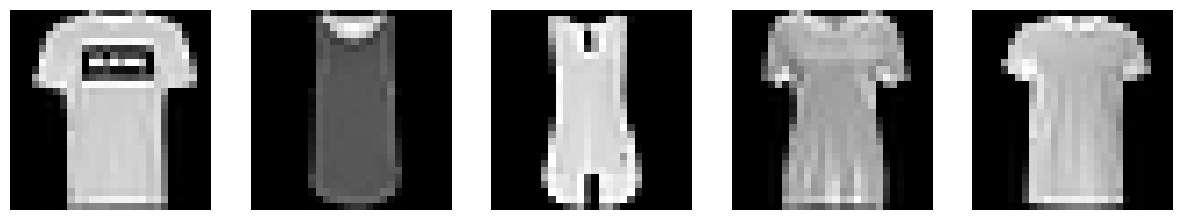


Class: Trouser


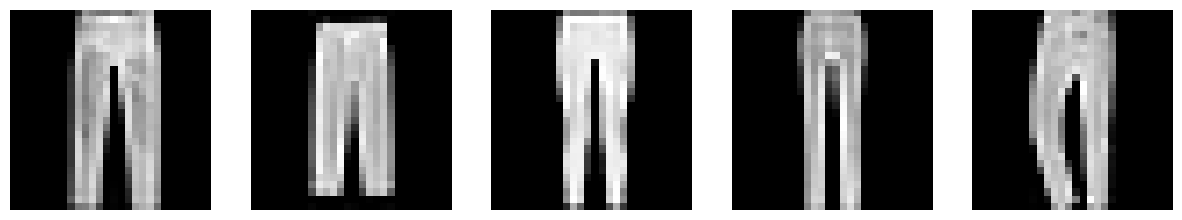


Class: Pullover


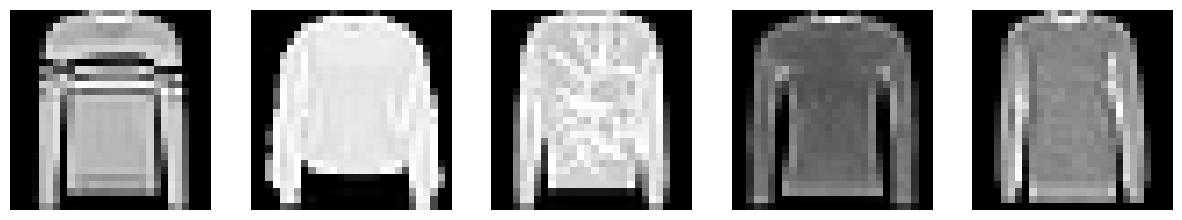


Class: Dress


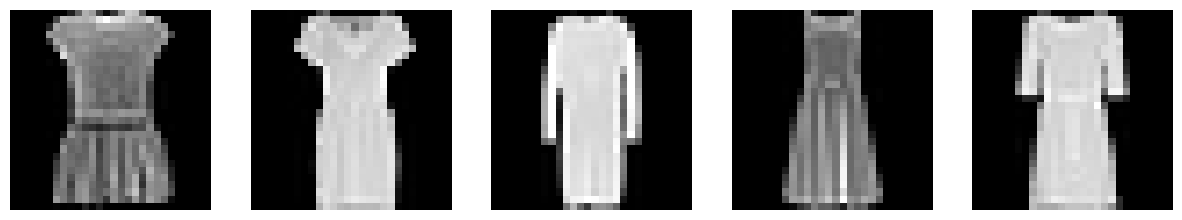


Class: Coat


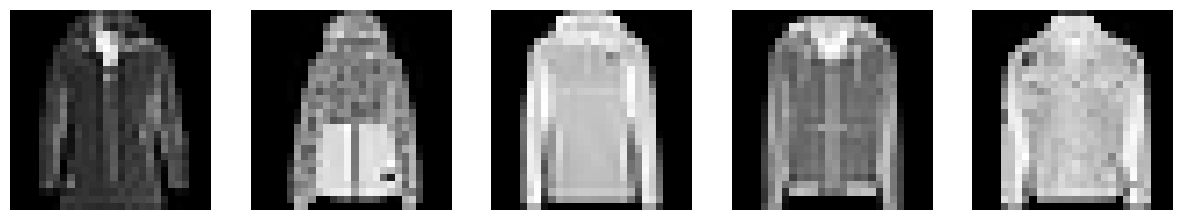


Class: Sandal


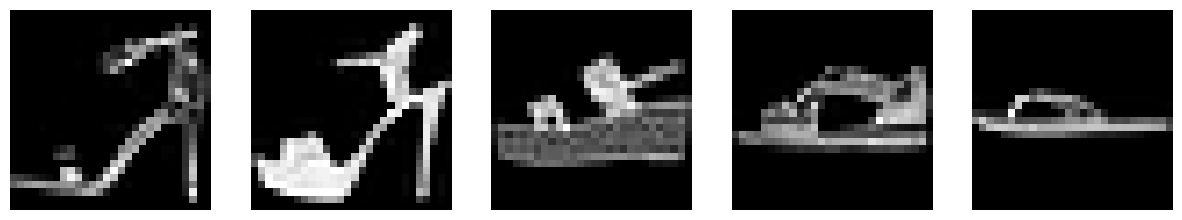


Class: Shirt


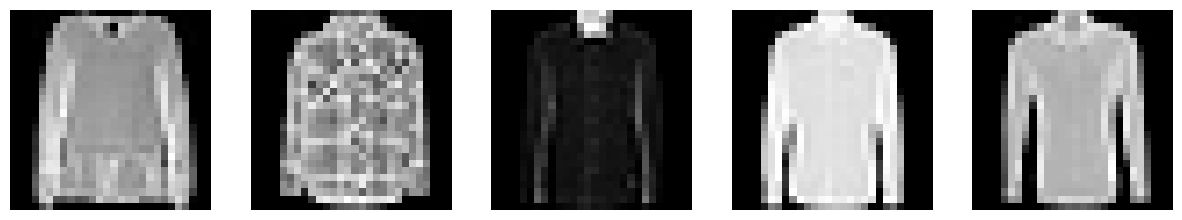


Class: Sneaker


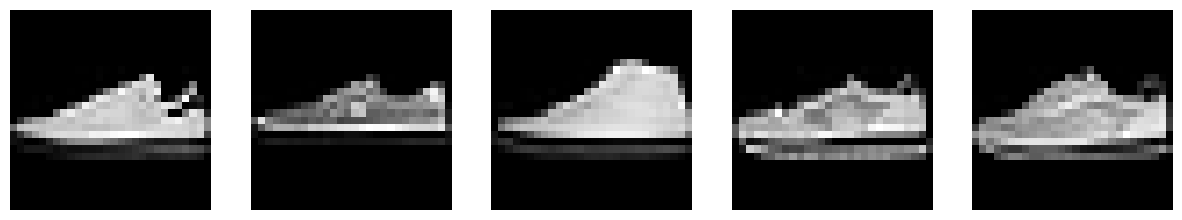


Class: Bag


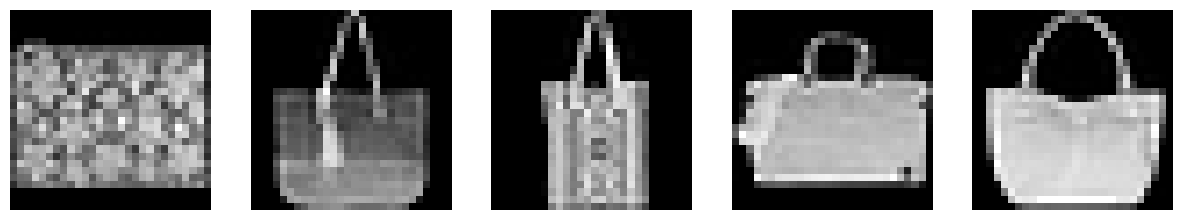


Class: Ankle boot


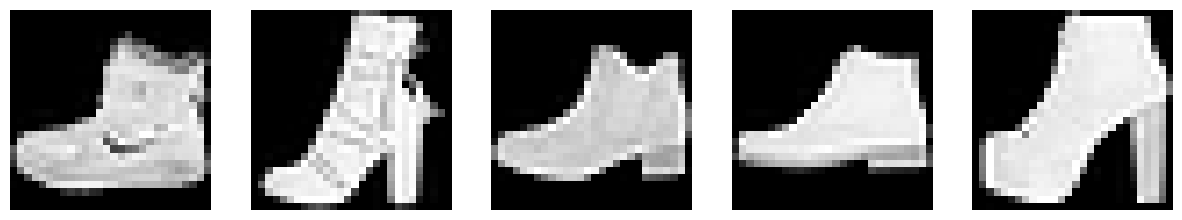

In [7]:
#Affichage d'images par classe du dataset Fashion-MNIST.

def plot_images_per_class(dataset, num_images_per_class=5):
    """Plots a specified number of images for each class in the FashionMNIST dataset."""

    class_labels = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    for class_index in range(10):
        class_images = []
        count = 0
        for image, label in dataset:
            if label == class_index and count < num_images_per_class:
                class_images.append(image)
                count += 1
            if count == num_images_per_class:
                break

        print(f"\nClass: {class_labels[class_index]}")
        fig, axes = plt.subplots(1, len(class_images), figsize=(15, 3)) # Adjust figure size for better display
        for i, image in enumerate(class_images):
          axes[i].imshow(image.squeeze(), cmap='gray')  # Use squeeze() to remove single-dimensional entries
          axes[i].axis('off')
        plt.show()

plot_images_per_class(dataset)

Du point de vue de l'**apparance** générale des images, les objets (vêtements, chaussures, sacs, etc.) sont représentés sous un format assez simple ce qui peut donner une sensation d'images plates en 2D et **peu détaillées** peut-être à cause de la petite taille des images et de leur **faible résolution**.

Du point de vue **couleur**, les images sont en niveaux de gris (noir et blanc), ce qui les rend relativement simples à traiter par les modèles d'apprentissage automatique. Cependant, cela signifie aussi qu'il y a **moins de détails** que dans des images en couleur.

En termes de **distribution des classes**, Fashion MNIST est bien équilibré, avec environ le même nombre d'images pour chaque catégorie (environ 6 000 images par classe dans les données d'entraînement). Cela garantit qu'aucune catégorie n'est sur-représentée ou sous-représentée **contrairement au Mini-Projet 1** ce qui permet une évaluation équitable des modèles.

Ce nombre d'images paraît largement suffisant pour les entraîner. Allons-y :

#2. Classification des données :

##**2.0. Introductions aux AE/CVAEs :**

Le CVAE est une extension du AE qui permet en plus de **contrôler la génération de données** en fonction d'une variable conditionnelle $y$. Imaginons que vous vouliouns générer des images de de la base de donnés Fasion-MNIST.  Avec un AE standard, nous obtiendrions des images de vêtements aléatoires. Avec un CVAE, nous pouvons spécifier quel type de vêtement nous voulons obtenir (par exemple, que des pantalons).


 - $x$ est l'entrée (image)
 - $y$ est la **condition** (le type de vetement) **(spécifique au CVAE)**
 - $x'$ est la sortie générée (image)
 - $z$ est le vecteur latent


                ┌─────────────┐               ┌────────────────┐
     x          │   Encoder   │               │   Decoder      │                 x'
     │─────────────►│  y  │──────────────────────►│  y , z  │───────────────────►
     │─────────────►          │               │                │
     y          └─────────────┘               └────────────────┘
         ▲                                           │
         │                                           │
         │            z (vecteur latent)             │
         └───────────────────────────────────────────┘



L'encodeur prend une entrée : $x$ et génère une distribution latente : $q(z|x)$ paramétrée par une moyenne : $\mu$ et un écart-type : $\sigma$ qui sont ensuite utilisés pour échantillonner le vecteur latent : $z|x = \mathcal{N}(\mu(x), \text{diag}(\sigma(x)^2))$. L'encodeur génère donc $\mu$  et $\log \sigma^2$ qui sont utilisés pour échantillonner \(z\).

Le décodeur prend la représentation latente $z$ (échantillonnée à partir de $q(z|x)$ et reconstruit l'entrée $\hat{x}$. La reconstruction est supposée suivre une distribution de probabilité : $ p(x|z) = \mathcal{N}(\hat{x}(z), I)$ où $\hat{x}(z)$ est l'image reconstruite à partir du vecteur latent $z$.



**Différences avec le AE standard:**   Un AE apprend une représentation latente des données, tandis qu'un CVAE apprend une représentation latente *conditionnelle* à une variable supplémentaire.  Ceci permet de contrôler et de diriger le processus de génération. Le CVAE prend donc une entrée supplémentaire `y`, qui représente la condition.  Cette condition peut être une classe (comme le type de vetement dans notre exemple), le AE n'a pas cette entrée. L'encodeur et le décodeur du CVAE intègrent cette information conditionnelle.


**Nous commençons par un AE standard puis passerons par un CVAE pour comparer les résultats de leurs classifications**

##**2.1: Classification AE :**

Nous définissons un autoencodeur standard avec un encodeur et un décodeur.


L'encodeur mappe l'entrée $x$ et les labels $y$ dans un espace latent de dimension $h$. Les données d'entrée sont d'abord aplaties, puis les labels sont concaténés à l'entrée avant d'être passés à travers deux couches linéaires. Soit $n$ le nombre d'exemples dans un lot,

Soit *$x \in \mathbb{R}^{n \times input\_size}$* et $y \in \mathbb{R}^{n \times labels\_length}$. *input_size* est la dimension des images aplaties (*784* pour des images *28x28* ) et *labels_length* correspond au nombre de classes (10 pour *Fashion-MNIST*)

$$z = \text{$ReLU$}(W_1 [x, y] + b_1)$$    $$h = W_2 z + b_2$$

où :

$\quad W_1 \in \mathbb{R}^{64 \times (input\_size + labels\_length)}$,

$\quad b_1 \in \mathbb{R}^{64}$,

$\quad W_2 \in \mathbb{R}^{hidden\_size \times 64}$,

$\quad b_2 \in \mathbb{R}^{hidden\_size}$,

et $\quad \text{ReLU}(x) = \max(0, x)$.



Le décodeur prend l'espace latent $h$ et les labels $y$ et reconstruit l'entrée d'origine.


 $$\hat{x} = \text{ReLU}(W_3 [h, y] + b_3) = W_4 \hat{z} + b_4$$



où :

$\quad W_3 \in \mathbb{R}^{64 \times (hidden\_size + labels\_length)}$

$\quad b_3 \in \mathbb{R}^{64}$

$\quad W_4 \in \mathbb{R}^{input\_size \times 64}$

$\quad b_4 \in \mathbb{R}^{input\_size}$.

**Batch size : 128.** Un batch size plus grand peut accélérer l'apprentissage mais nécessite plus de mémoire. Ici, 128 est choisi comme un bon compromis entre vitesse et performances.



In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size + labels_length, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size))

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + labels_length, 64),
            nn.ReLU(True),
            nn.Linear(64, input_size),
            nn.Tanh())

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x,labels),dim=1)
        return self.encoder(x)

    def decode(self, x, labels):
        x = torch.cat((x,labels),dim=1)
        return self.decoder(x)

    def forward(self, x, labels):
        x = self.encode(x,labels)
        x = self.decode(x,labels)

        return x


**Fonction de perte :**



La MSE minimise la différence au carré entre l'image d'entrée et l'image reconstruite. C'est mieux car elle est particulièrement adaptée pour des images dans lesquelles les pixels ont des valeurs réelles (par exemple, de 0 à 255 pour une image en niveaux de gris).


$$\text{MSE}(x, \hat{x}) = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2$$

 où $x_i$ et $\hat{x}_i$ sont les valeurs de l'entrée et de la reconstruction à la position $i$ respectivement.


In [9]:
model = autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs,labels)
        loss = criterion(outputs, inputs.view(-1,28*28))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    inp,out = [],[]
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs,labels)
            loss = criterion(outputs, inputs.view(-1,28*28))
            inp,out = inputs, outputs

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].cpu(),out[0].cpu()],28,28,1,2)

    val_loss = running_loss / processed_size
    return val_loss

def train(train_loader, val_loader, model, epochs, batch_size):
    history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            val_loss = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))
    return history

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.14058374423265457


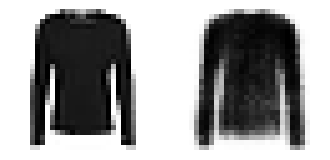

epoch:   5%|▌         | 1/20 [00:13<04:17, 13.55s/it]


Epoch 001 train_loss: 0.1406 val_loss 0.0852
loss 0.07817715013742448


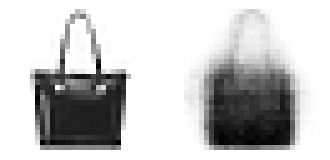

epoch:  10%|█         | 2/20 [00:26<03:57, 13.20s/it]


Epoch 002 train_loss: 0.0782 val_loss 0.0748
loss 0.07205350551366806


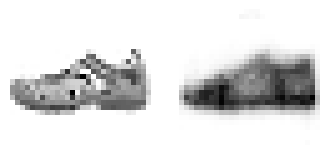

epoch:  15%|█▌        | 3/20 [00:39<03:43, 13.16s/it]


Epoch 003 train_loss: 0.0721 val_loss 0.0709
loss 0.06890654843330384


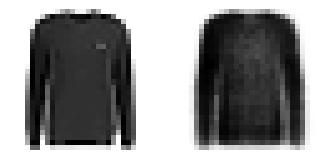

epoch:  20%|██        | 4/20 [00:52<03:28, 13.01s/it]


Epoch 004 train_loss: 0.0689 val_loss 0.0683
loss 0.06674703813076019


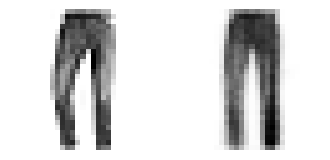

epoch:  25%|██▌       | 5/20 [01:05<03:18, 13.22s/it]


Epoch 005 train_loss: 0.0667 val_loss 0.0665
loss 0.06507299143791198


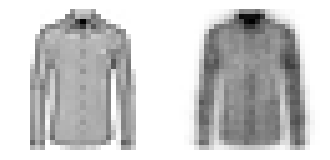

epoch:  30%|███       | 6/20 [01:18<03:03, 13.11s/it]


Epoch 006 train_loss: 0.0651 val_loss 0.0651
loss 0.06382026658535003


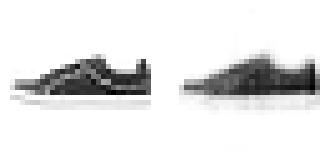

epoch:  35%|███▌      | 7/20 [01:31<02:49, 13.03s/it]


Epoch 007 train_loss: 0.0638 val_loss 0.0640
loss 0.06290751186966896


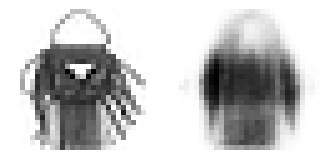

epoch:  40%|████      | 8/20 [01:44<02:36, 13.03s/it]


Epoch 008 train_loss: 0.0629 val_loss 0.0630
loss 0.06206427033662796


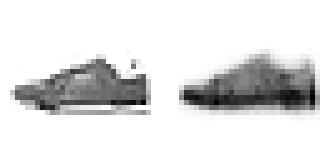

epoch:  45%|████▌     | 9/20 [01:57<02:22, 12.97s/it]


Epoch 009 train_loss: 0.0621 val_loss 0.0626
loss 0.0614548836517334


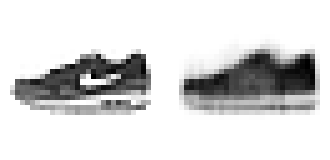

epoch:  50%|█████     | 10/20 [02:10<02:09, 12.97s/it]


Epoch 010 train_loss: 0.0615 val_loss 0.0617
loss 0.060878931295871734


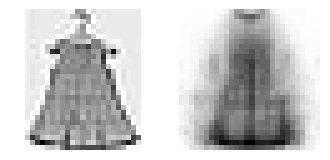

epoch:  55%|█████▌    | 11/20 [02:23<01:56, 12.94s/it]


Epoch 011 train_loss: 0.0609 val_loss 0.0615
loss 0.06038847667574883


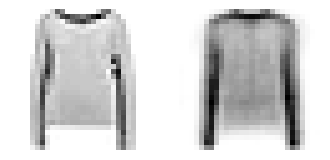

epoch:  60%|██████    | 12/20 [02:36<01:43, 12.93s/it]


Epoch 012 train_loss: 0.0604 val_loss 0.0609
loss 0.05996539937019348


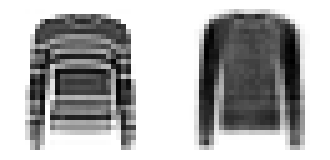

epoch:  65%|██████▌   | 13/20 [02:49<01:30, 12.88s/it]


Epoch 013 train_loss: 0.0600 val_loss 0.0604
loss 0.05956233598709106


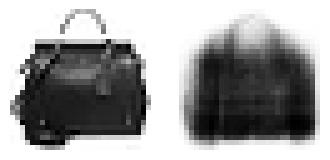

epoch:  70%|███████   | 14/20 [03:01<01:17, 12.84s/it]


Epoch 014 train_loss: 0.0596 val_loss 0.0603
loss 0.05925814198255539


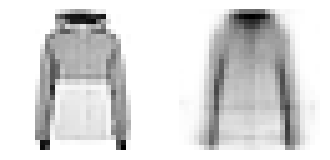

epoch:  75%|███████▌  | 15/20 [03:14<01:04, 12.86s/it]


Epoch 015 train_loss: 0.0593 val_loss 0.0598
loss 0.05894535479187965


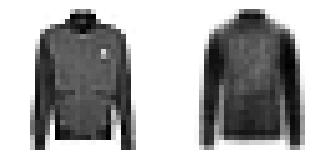

epoch:  80%|████████  | 16/20 [03:27<00:51, 12.87s/it]


Epoch 016 train_loss: 0.0589 val_loss 0.0597
loss 0.05870092789888382


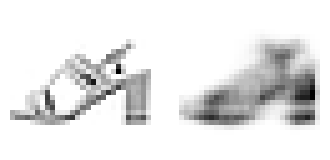

epoch:  85%|████████▌ | 17/20 [03:40<00:38, 12.84s/it]


Epoch 017 train_loss: 0.0587 val_loss 0.0592
loss 0.058423819637298584


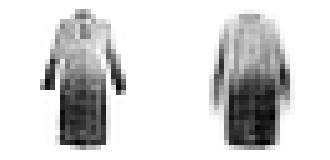

epoch:  90%|█████████ | 18/20 [03:53<00:25, 12.87s/it]


Epoch 018 train_loss: 0.0584 val_loss 0.0590
loss 0.05818069090366364


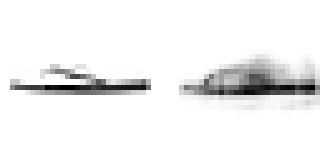

epoch:  95%|█████████▌| 19/20 [04:06<00:12, 12.92s/it]


Epoch 019 train_loss: 0.0582 val_loss 0.0589
loss 0.0579779937171936


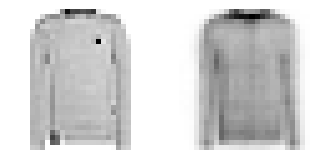

epoch: 100%|██████████| 20/20 [04:19<00:00, 12.97s/it]


Epoch 020 train_loss: 0.0580 val_loss 0.0586


In [11]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=128)

##**2.2. Visualisations AE :**


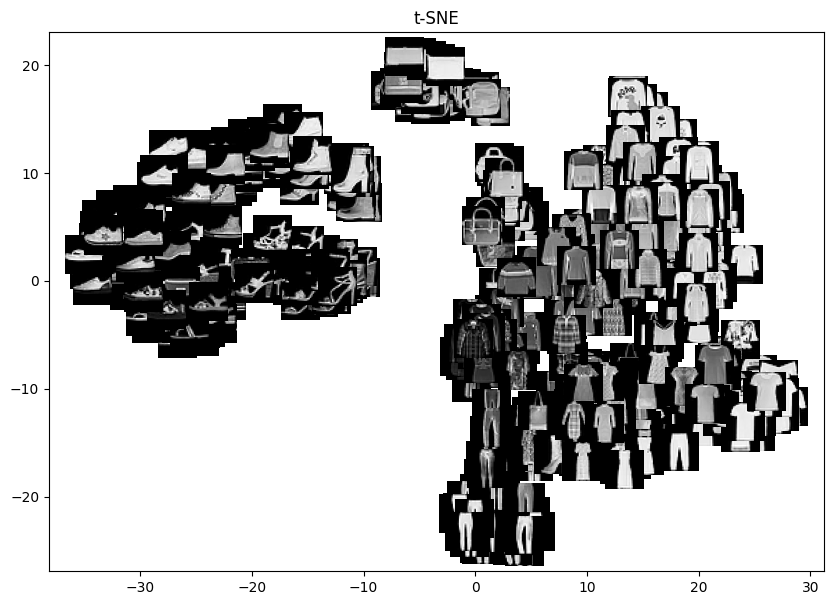

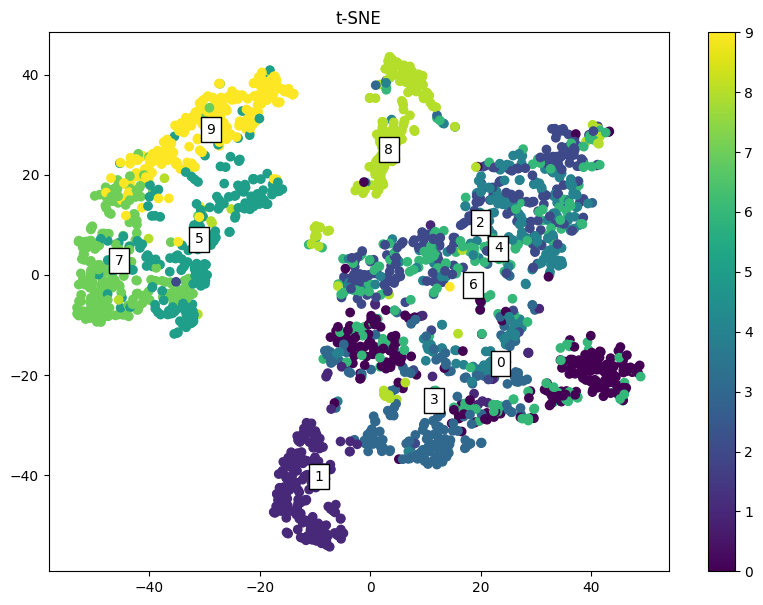

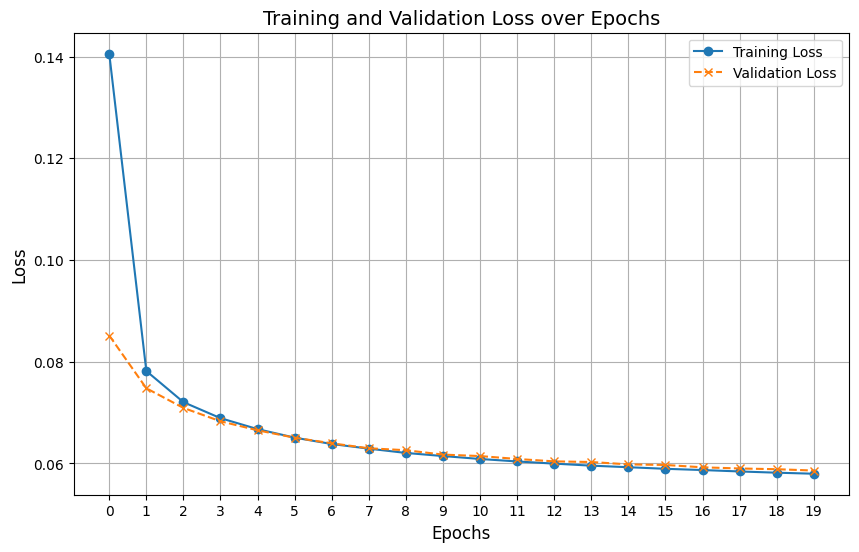

In [12]:
plot_tsne(net=model, mode='imgs', count=300)
plot_tsne(net=model, mode='dots', count=2000)

if isinstance(history[0], tuple):
    train_losses, val_losses = zip(*history)

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(val_losses, label='Validation Loss', marker='x', linestyle='--')


    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss over Epochs', fontsize=14)
    plt.grid(True)
    plt.xticks(range(len(train_losses)))
    plt.legend()
    plt.show()

Les données réparties en 10 classes sont à moitié bien classifiées,
les classes 2, 4 et 6 sont les plus mélangées (**pull-over, meanteau et chemises**) ce qui peut s'explique du part la complexité de les différencier entre eux.

La perte est plutôt faible et il n'y a pas d'écart significatif entre les données de validation et de test, ce qui indique qu'il n'y a pas de risque de surapprentissage.

**L' utilisation d'un CVAE paraît intéressante pour améliorer les résultats**

##**2.3. Classification CVAE :**

Nous passons désormais à un entraînement par CVAE, celui ci necessit des modifications :


Nous appliquons une série d'amélioration :

###**Changements sur l'encodeur** :

L'encodeur prend toujours en entrée les images $x \in \mathbb{R}^{n \times input\_size}$  et les labels $y \in \mathbb{R}^{n \times labels\_length}$, et les concatène pour créer une entrée $[x, y]$. Mais cette fois, cette entrée passe par une couche linéaire et une **normalisation par lot :**  

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

puis l'activation : $\text{ReLU}(x) = \max(0, x)$

$$\text{Encoder}(x, y) = \mu, \log(\sigma^2)$$

L'encodeur produit 2 sorties : la **moyenne $\mu$** (centre de la distribution gaussienne latente) et **la log-variance $\log(\sigma^2)$** qui traduit la dispersion de la distribution.

###**Reparamétrisation trick** :

Ensuite on échantillonne à partir de la distribution $\mathcal{N}(\mu, \sigma^2)$ de manière différentiable.

Il permet un échantillonnage différentiable et stable, facilitant l'optimisation des modèles $$z = \mu + \sigma \cdot \epsilon$$

où   $\epsilon \sim \mathcal{N}(0, I)$ est un bruit aléatoire tiré d'une distribution normale standard,

et $\sigma = \exp(0.5 \log(\sigma^2))$.

###**Changements sur le decodeur** :

Le décodeur prend l'échantillon latent $z$ ainsi que les labels $y$, et les concatène avant de les passer à travers un réseau pour générer la reconstruction $\hat{x}$ de l'image d'entrée : $$\hat{x} = \text{Decoder}(z, y)$$. Cette image reconstruite est ensuite normalisée par une fonction sigmoïde pour garantir que ses valeurs de pixels sont dans l'intervalle $[0, 1]$.

###**fonction de perte :**



$$\text{Loss} = \text{MSE}(x, \hat{x}) + \text{KLD}(q(z|x) || p(z))$$

Cette fonction est la somme de la MSE et de la KLD : permet de maximiser la qualité de la reconstruction tout en régularisant l'espace latent, ce qui améliore la génération d'images.


La **MSE** minimise la différence au carré entre l'image d'entrée et l'image reconstruite. C'est mieux car elle est particulièrement adaptée pour des images dans lesquelles les pixels ont des valeurs réelles (par exemple, de 0 à 255 pour une image en niveaux de gris).


$$\text{MSE}(x, \hat{x}) = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2$$

 où

* $x_i$ et  valeurs de l'entrée et de à la position $i$

* $\hat{x}_i$ valeurs de la reconstruction à la position $i$

La perte $KLD$ (Kullback-Leibler Divergence) pénalise la divergence entre la distribution latente apprise $q(z|x)$ et une distribution Gaussienne normale standard $p(z) = \mathcal{N}(0, I)$ : $$\text{KLD} ( q(z|x) || p(z)) = -\frac{1}{2} \sum_{i} \left( 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2 \right)$$

où :

* $\mu_i$ et $\sigma_i^2$ sont les paramètres de la distribution latente générée par l'encodeur.

* $p(z) = \mathcal{N}(0, I)$ est la distribution normale standard.



###**Mise à jour des hyperparamètres**:

**Batch size : 128.** Un batch size plus grand peut accélérer l'apprentissage mais nécessite plus de mémoire. Ici, 128 est choisi comme un bon compromis entre vitesse et performances.

**Learning rate : 0.001.** Le taux d'apprentissage contrôle la taille des pas de mise à jour des poids du modèle pendant l'apprentissage.  Une valeur trop élevée peut entraîner une divergence, alors qu'une valeur trop faible ralentit l'apprentissage. 0.005 est sélectionné comme un point de départ, pouvant être adapté.

**Nombre d'epochs : 20 -> 50**. Un nombre d'epochs trop faible peut entraîner un sous-apprentissage tandis qu'un nombre trop élevé peut entraîner un sur-apprentissage...



In [ ]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), 28*28)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],28,28,1,2)

    losses.append((sum(loss_sum)/len(loss_sum)).item())

In [ ]:
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size=20):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length

        self.fc1 = nn.Linear(input_size_with_label, 512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)

        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size + labels_length, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(hidden_size)

    def encode(self, x, labels):
        x = x.view(-1, 1 * 28 * 28)  # Flatten
        x = torch.cat((x, labels), 1)  # Concatenate
        x = self.relu(self.bn1(self.fc1(x)))
        return self.fc21(x), self.fc22(x)

    def decode(self, z, labels):
        z = torch.cat((z, labels), 1)  # Concatenate
        z = self.relu(self.bn3(self.fc3(z)))
        return torch.sigmoid(self.fc4(z))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar

def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')  # Use MSE loss instead
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=50):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters(), lr=0.001)  # Adjust learning rate

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = F.one_hot(labels, num_classes=labels_length).float().to(DEVICE)  # One-hot encoding

                # Normalize input 'batch' to the range [0, 1]
                batch = batch / 255.0  # Normalizing for Fashion MNIST

                if flatten:
                    batch = batch.view(batch.size(0), 28 * 28)

                optim.zero_grad()
                x, mu, logvar = net(batch, labels)
                x = torch.clamp(x, 0, 1)  # Clamp output between 0 and 1
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i + 1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

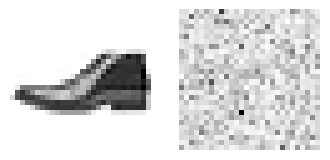

epoch:   2%|▏         | 1/50 [00:15<12:34, 15.41s/it]


Epoch 001 val_loss 0.7238


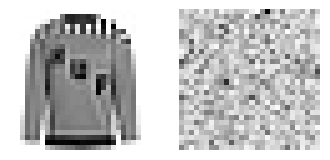

epoch:   4%|▍         | 2/50 [00:34<14:14, 17.80s/it]


Epoch 002 val_loss 0.7007


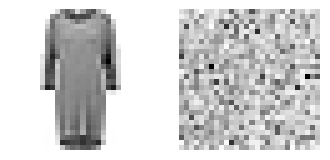

epoch:   6%|▌         | 3/50 [00:52<13:51, 17.69s/it]


Epoch 003 val_loss 0.6933


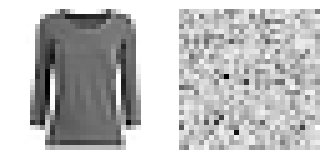

epoch:   8%|▊         | 4/50 [01:08<13:03, 17.02s/it]


Epoch 004 val_loss 0.6889


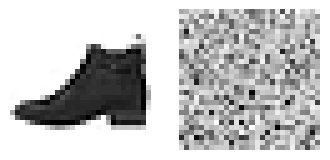

epoch:  10%|█         | 5/50 [01:26<12:57, 17.27s/it]


Epoch 005 val_loss 0.6878


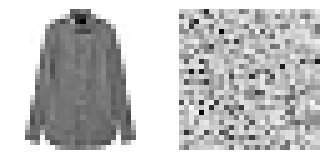

epoch:  12%|█▏        | 6/50 [01:44<12:51, 17.53s/it]


Epoch 006 val_loss 0.6858


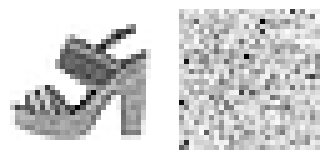

epoch:  14%|█▍        | 7/50 [02:03<13:04, 18.25s/it]


Epoch 007 val_loss 0.6850


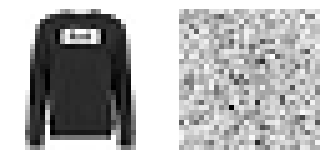

epoch:  16%|█▌        | 8/50 [02:21<12:32, 17.93s/it]


Epoch 008 val_loss 0.6854


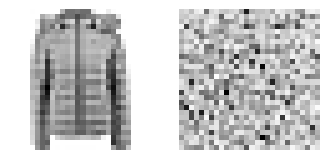

epoch:  18%|█▊        | 9/50 [02:36<11:46, 17.22s/it]


Epoch 009 val_loss 0.6834


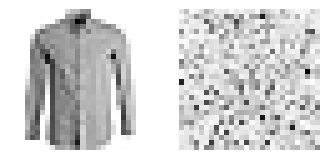

epoch:  20%|██        | 10/50 [02:52<11:12, 16.82s/it]


Epoch 010 val_loss 0.6838


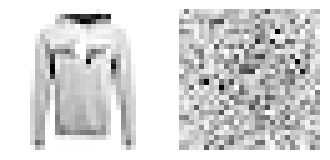

epoch:  22%|██▏       | 11/50 [03:09<11:00, 16.93s/it]


Epoch 011 val_loss 0.6833


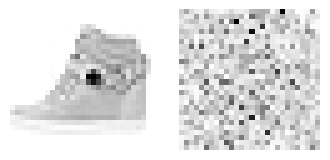

epoch:  24%|██▍       | 12/50 [03:27<10:55, 17.25s/it]


Epoch 012 val_loss 0.6829


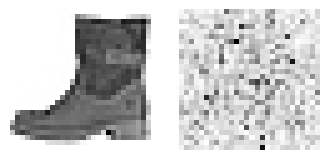

epoch:  26%|██▌       | 13/50 [03:45<10:44, 17.43s/it]


Epoch 013 val_loss 0.6824


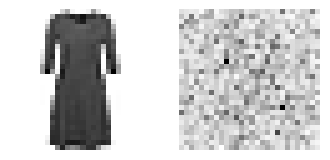

epoch:  28%|██▊       | 14/50 [04:04<10:41, 17.83s/it]


Epoch 014 val_loss 0.6823


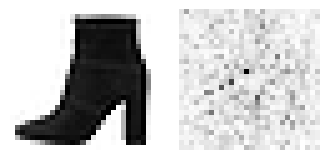

epoch:  30%|███       | 15/50 [04:21<10:20, 17.72s/it]


Epoch 015 val_loss 0.6827


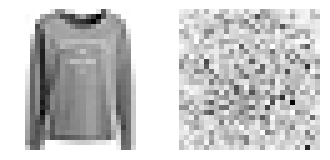

epoch:  32%|███▏      | 16/50 [04:37<09:42, 17.13s/it]


Epoch 016 val_loss 0.6822


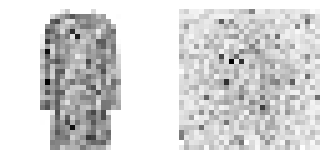

epoch:  34%|███▍      | 17/50 [04:54<09:18, 16.94s/it]


Epoch 017 val_loss 0.6821


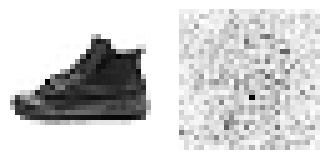

epoch:  36%|███▌      | 18/50 [05:11<09:03, 16.98s/it]


Epoch 018 val_loss 0.6820


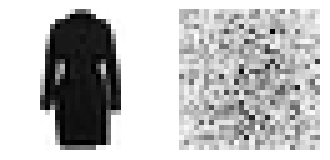

epoch:  38%|███▊      | 19/50 [05:29<08:58, 17.36s/it]


Epoch 019 val_loss 0.6814


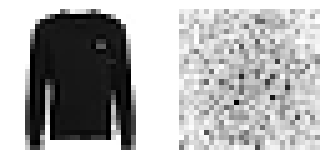

epoch:  40%|████      | 20/50 [05:45<08:23, 16.80s/it]


Epoch 020 val_loss 0.6808


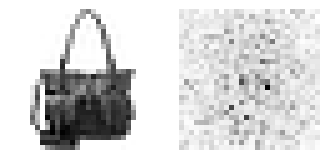

epoch:  42%|████▏     | 21/50 [06:02<08:12, 16.98s/it]


Epoch 021 val_loss 0.6816


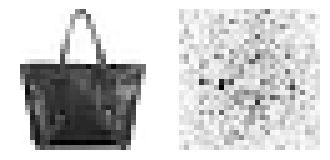

epoch:  44%|████▍     | 22/50 [06:18<07:51, 16.85s/it]


Epoch 022 val_loss 0.6816


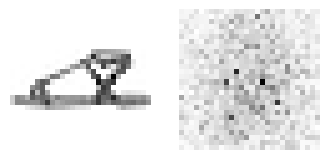

epoch:  46%|████▌     | 23/50 [06:34<07:23, 16.43s/it]


Epoch 023 val_loss 0.6817


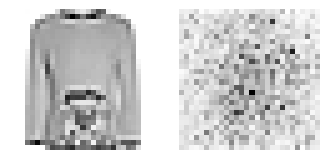

epoch:  48%|████▊     | 24/50 [06:53<07:24, 17.08s/it]


Epoch 024 val_loss 0.6815


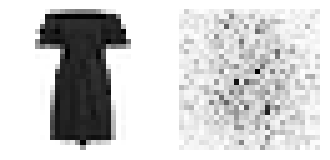

epoch:  50%|█████     | 25/50 [07:09<07:04, 17.00s/it]


Epoch 025 val_loss 0.6809


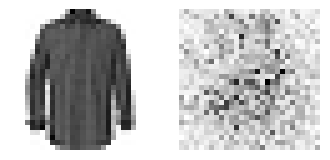

epoch:  52%|█████▏    | 26/50 [07:29<07:09, 17.88s/it]


Epoch 026 val_loss 0.6816


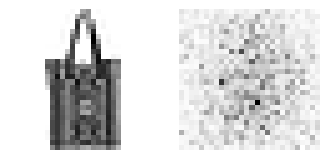

epoch:  54%|█████▍    | 27/50 [07:48<06:56, 18.10s/it]


Epoch 027 val_loss 0.6818


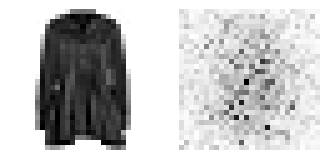

epoch:  56%|█████▌    | 28/50 [08:05<06:34, 17.94s/it]


Epoch 028 val_loss 0.6812


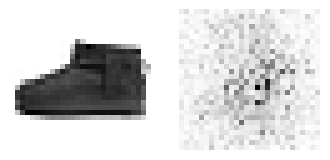

epoch:  58%|█████▊    | 29/50 [08:22<06:05, 17.41s/it]


Epoch 029 val_loss 0.6814


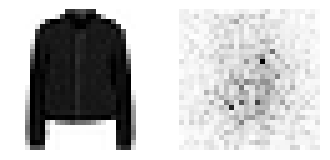

epoch:  60%|██████    | 30/50 [08:40<05:56, 17.82s/it]


Epoch 030 val_loss 0.6813


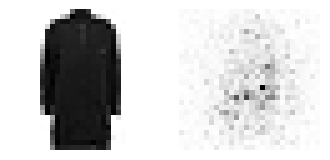

epoch:  62%|██████▏   | 31/50 [08:59<05:40, 17.92s/it]


Epoch 031 val_loss 0.6815


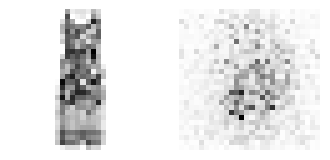

epoch:  64%|██████▍   | 32/50 [09:16<05:17, 17.66s/it]


Epoch 032 val_loss 0.6811


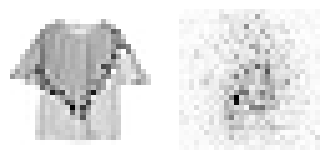

epoch:  66%|██████▌   | 33/50 [09:33<04:59, 17.60s/it]


Epoch 033 val_loss 0.6806


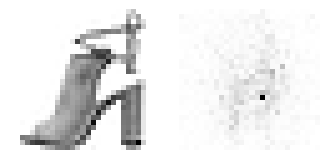

epoch:  68%|██████▊   | 34/50 [09:49<04:32, 17.01s/it]


Epoch 034 val_loss 0.6808


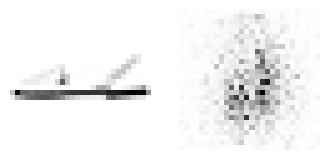

epoch:  70%|███████   | 35/50 [10:05<04:12, 16.82s/it]


Epoch 035 val_loss 0.6812


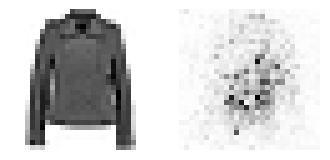

epoch:  72%|███████▏  | 36/50 [10:21<03:51, 16.53s/it]


Epoch 036 val_loss 0.6812


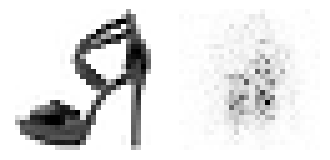

epoch:  74%|███████▍  | 37/50 [10:41<03:49, 17.67s/it]


Epoch 037 val_loss 0.6814


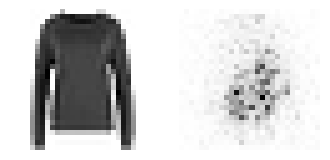

epoch:  76%|███████▌  | 38/50 [10:57<03:26, 17.19s/it]


Epoch 038 val_loss 0.6809


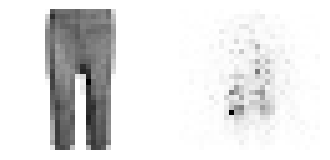

epoch:  78%|███████▊  | 39/50 [11:13<03:03, 16.70s/it]


Epoch 039 val_loss 0.6812


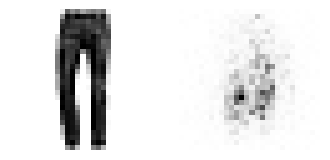

epoch:  80%|████████  | 40/50 [11:33<02:57, 17.78s/it]


Epoch 040 val_loss 0.6806


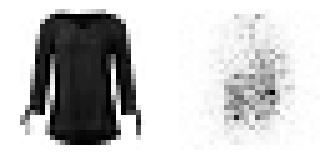

epoch:  82%|████████▏ | 41/50 [11:50<02:36, 17.36s/it]


Epoch 041 val_loss 0.6811


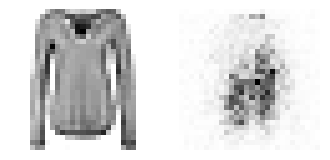

epoch:  84%|████████▍ | 42/50 [12:07<02:20, 17.52s/it]


Epoch 042 val_loss 0.6817


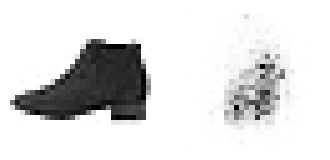

epoch:  86%|████████▌ | 43/50 [12:27<02:06, 18.10s/it]


Epoch 043 val_loss 0.6809


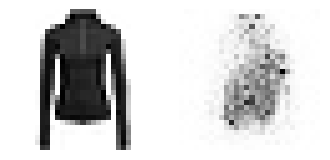

epoch:  88%|████████▊ | 44/50 [12:46<01:50, 18.41s/it]


Epoch 044 val_loss 0.6813


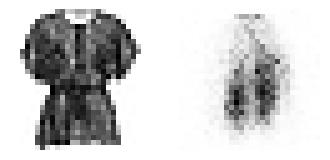

epoch:  90%|█████████ | 45/50 [13:02<01:29, 17.81s/it]


Epoch 045 val_loss 0.6809


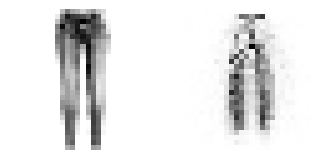

epoch:  92%|█████████▏| 46/50 [13:19<01:09, 17.29s/it]


Epoch 046 val_loss 0.6813


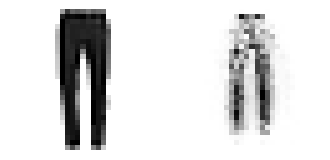

epoch:  94%|█████████▍| 47/50 [13:34<00:50, 16.81s/it]


Epoch 047 val_loss 0.6813


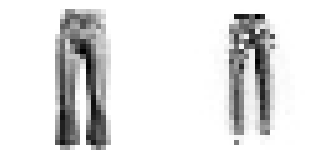

epoch:  96%|█████████▌| 48/50 [13:50<00:33, 16.51s/it]


Epoch 048 val_loss 0.6811


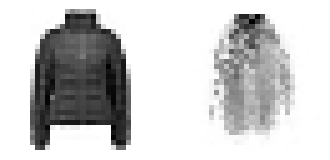

epoch:  98%|█████████▊| 49/50 [14:08<00:16, 16.83s/it]


Epoch 049 val_loss 0.6809


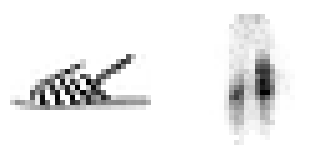

epoch: 100%|██████████| 50/50 [14:25<00:00, 17.32s/it]


Epoch 050 val_loss 0.6811


In [ ]:
# Initialize and train the CVAE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels_length = 10

# Initialize the CVAE
cvae = CVAE(28 * 28).to(DEVICE)

history_cvae = train_cvae(cvae, train_dataset, val_dataset)

## **2.2. Visualisations CVAE :**

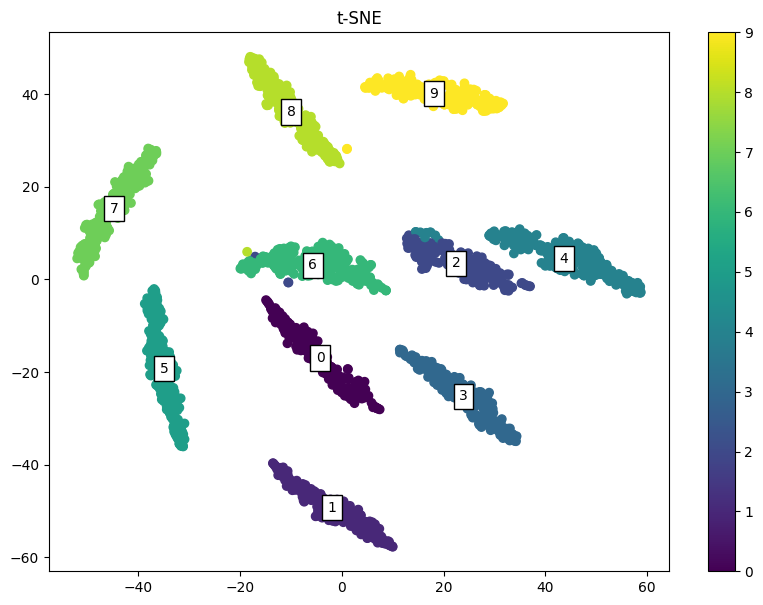

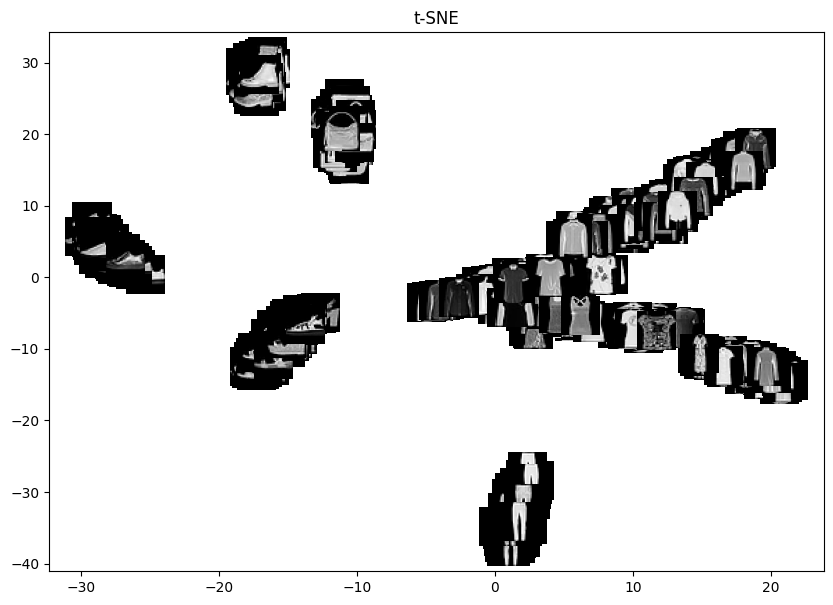

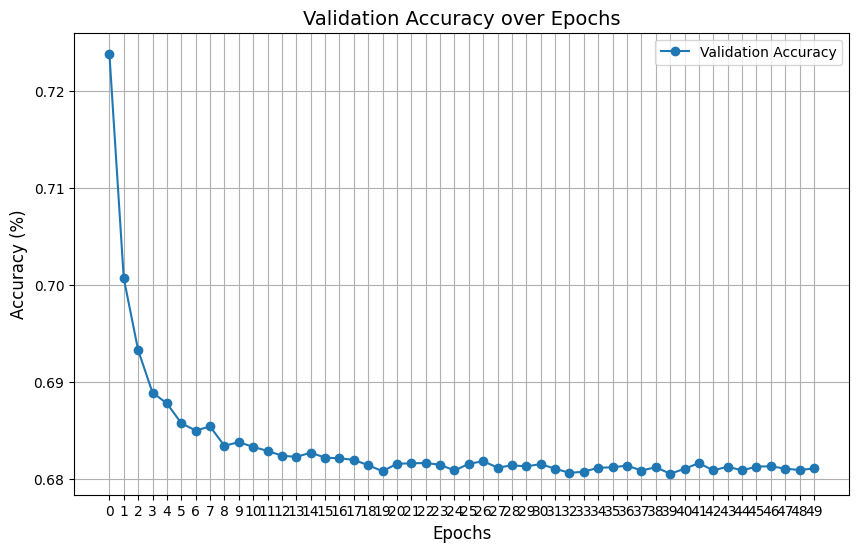

In [ ]:
#Résultats model CVAE
plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)

plt.figure(figsize=(10, 6))
plt.plot(history_cvae, label='Validation Accuracy', marker='o', linestyle='-') #Plot précision

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Validation Accuracy over Epochs', fontsize=14)
plt.grid(True)
plt.xticks(range(len(history_cvae)))
plt.legend()
plt.show()


In [ ]:
average_accuracy = np.mean(history_cvae)
print(f"Average Validation Accuracy: {average_accuracy:.2f}%")

Average Validation Accuracy: 0.68%


In [ ]:
if history_cvae:
  print("TEST")
  print("Validation Accuracy:", history_cvae[-1]) #Précision finale
else:
  print("history_cvae is empty. No accuracy to display.")

TEST
Validation Accuracy: 0.6811001896858215


Il est clair que la classification par CVAE est meilleure que sans, les classes sont clairement mieux classifiées, il y'a très peu d'erreur : le train validation converge sur un bon 7/10.

Les hautes, robes et vestes sont des catégories qui se ressemblent, elles sont très proche, idem pour les talons et les autres types de chaussures qui ont également la même taille. Il serait difficile de mieux les classifier au vue de la qualité des images du dataset vu au début du projet.

# 4. Génération de nouveaux échantillons :


Nous allons génerer des images à partir de l'espace latent du $CVAE$ pour chaque classe, en échantillonnant des vecteurs latents aléatoires et en les décodant à l'aide du modèle. Ensuite, il calcule l'erreur de reconstruction (MSE) pour chaque image.

Pour chaque classe, un vecteur latent aléatoire $z$ de dimension 20 est échantillonné depuis une distribution normale : $z \sim \mathcal{N}(0, I)$


Ensuite, ce vecteur latent est concaténé avec un vecteur one-hot encodé pour le label de la classe $y$, formant un vecteur d'entrée $x_{\text{input}}$ pour le décodeur :


$$x_{\text{input}} = \text{concat}(z, y)$$

**Le décodeur du CVAE génère une image $\hat{x}$ à partir de  $x_{\text{input}}$.**

Class: T-shirt/top


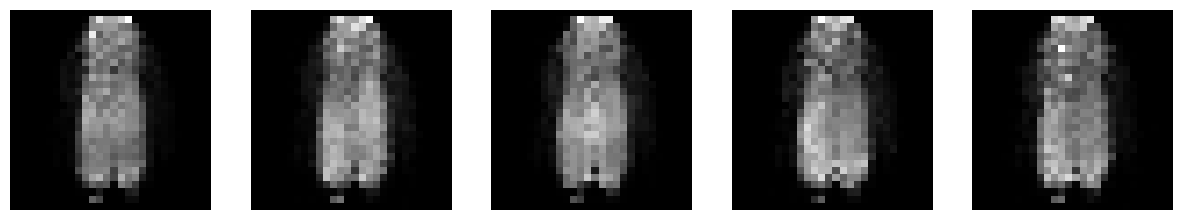

Class: Trouser


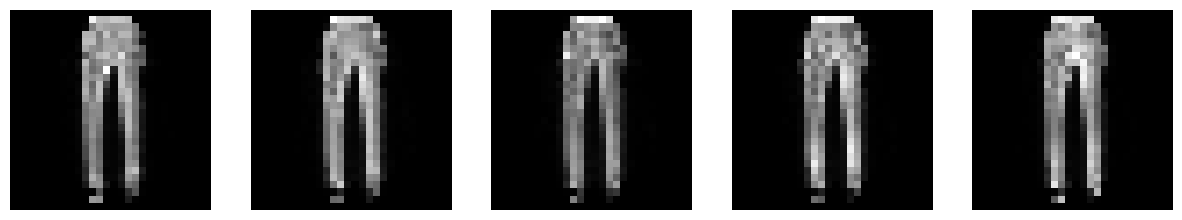

Class: Pullover


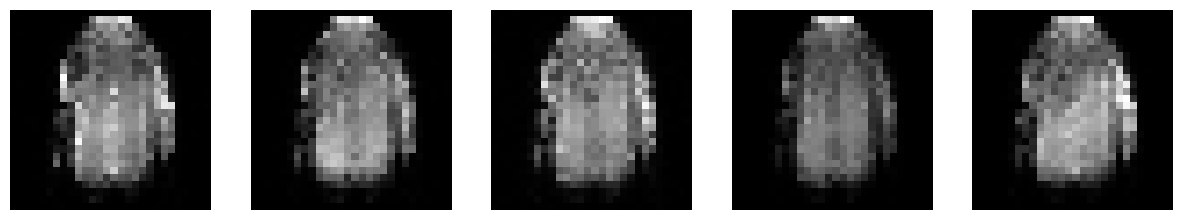

Class: Dress


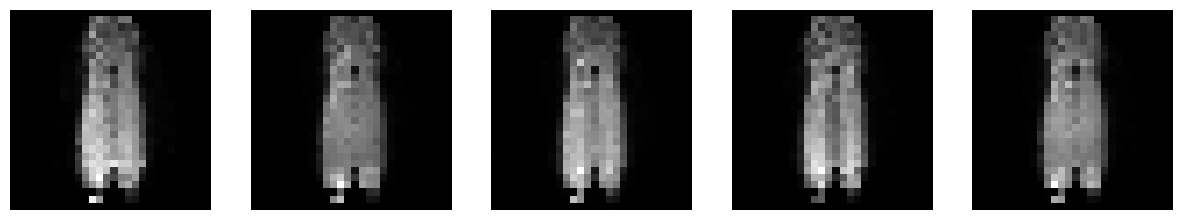

Class: Coat


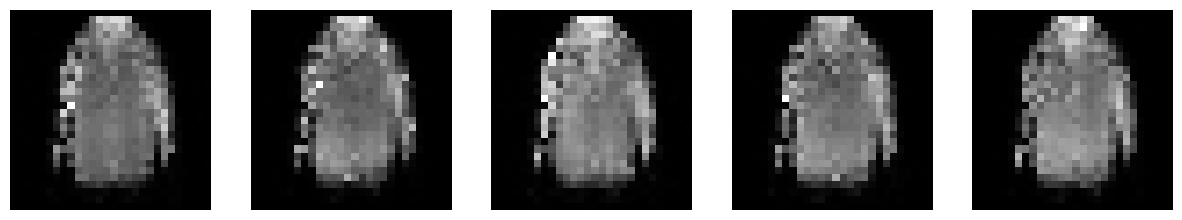

Class: Sandal


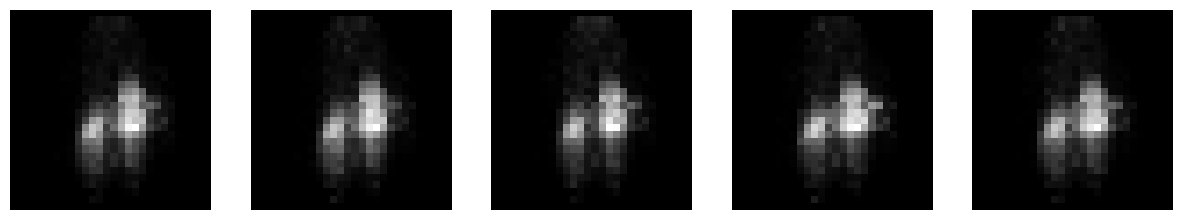

Class: Shirt


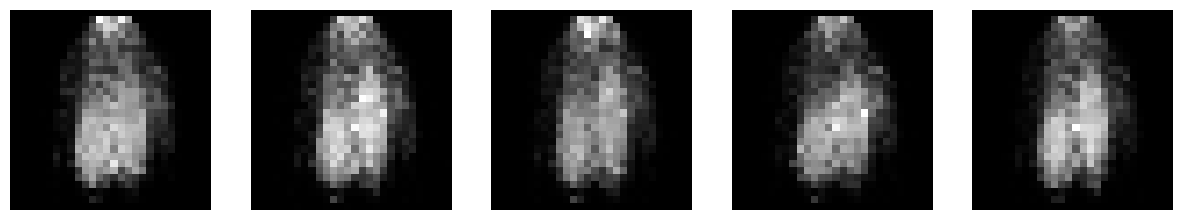

Class: Sneaker


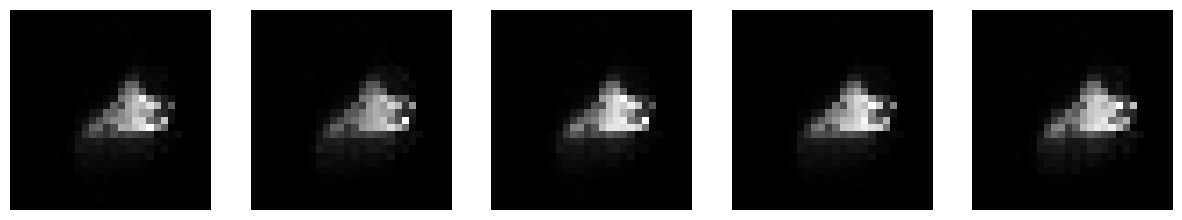

Class: Bag


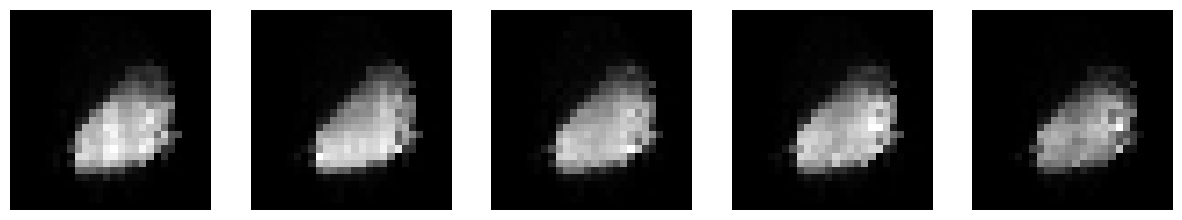

Class: Ankle boot


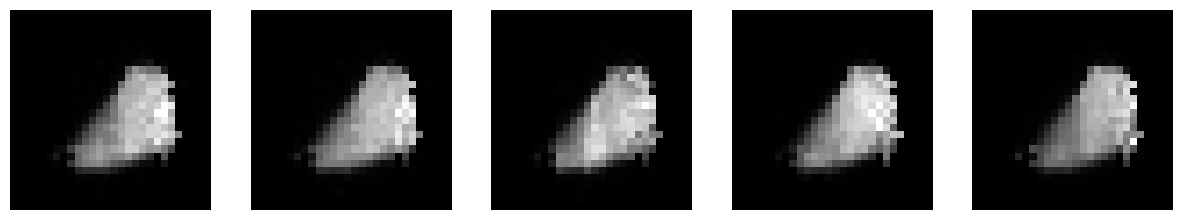

In [ ]:
def generate_new_samples(cvae, dataset, num_samples_per_class=5, device=DEVICE):
    cvae.eval()
    generated_samples = []
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }
    for class_index in range(10):
        class_samples = []
        for _ in range(num_samples_per_class):
            for image, label in dataset:
                if label == class_index:
                    real_image = image.to(device)
                    real_label = F.one_hot(torch.tensor([label]), num_classes=labels_length).float().to(device)
                    break


            real_image = real_image / 255.0
            real_image = real_image.view(1, 28 * 28)  # Flatten


            with torch.no_grad():  # No need for gradient calculation
              generated_image, _, _ = cvae(real_image, real_label)

            generated_image = generated_image.view(28, 28).cpu().numpy() # Reshape and bring to CPU
            class_samples.append(generated_image)
        generated_samples.append(class_samples)
    return generated_samples, class_names #return class_names


# Example usage:
new_samples, class_names = generate_new_samples(cvae, dataset)

# Displaying the generated images
for class_index in range(10):
    print(f"Class: {class_names[class_index]}")
    fig, axes = plt.subplots(1, len(new_samples[class_index]), figsize=(15, 3))
    for i, image in enumerate(new_samples[class_index]):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    plt.show()

Nous obtenons des reconstructions corrects pour les images de grande taille(veste, pantalon, manteau...), néanmoins la reconstruction est plus compliqué pour les petits objets (sacs et chaussures). Mesurons l'**erreur de reconstruction pour chaque image** :

$$MSE = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2$$

où $x_i$ est l'image originale et $\hat{x}_i$ est l'image reconstruite. $N$ est le nombre total de pixels dans l'image (28x28 ici).


Les images originales $x_i$ et reconstruites $\hat{x}_i$ sont affichées côte à côte avec leur MSE correspondant. Chaque image reconstruite est accompagnée du MSE calculé :

$$\hat{x}_i = f(x_{\text{input}})$$

où $f$ représente la fonction de décodage du $CVAE$.


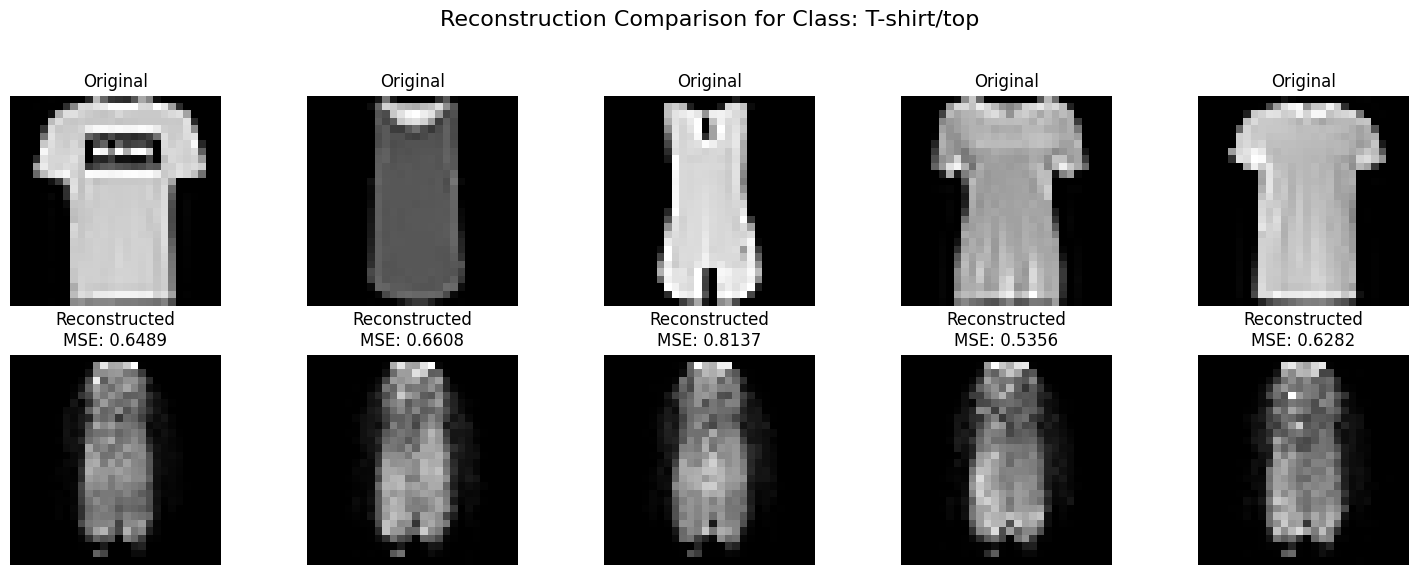

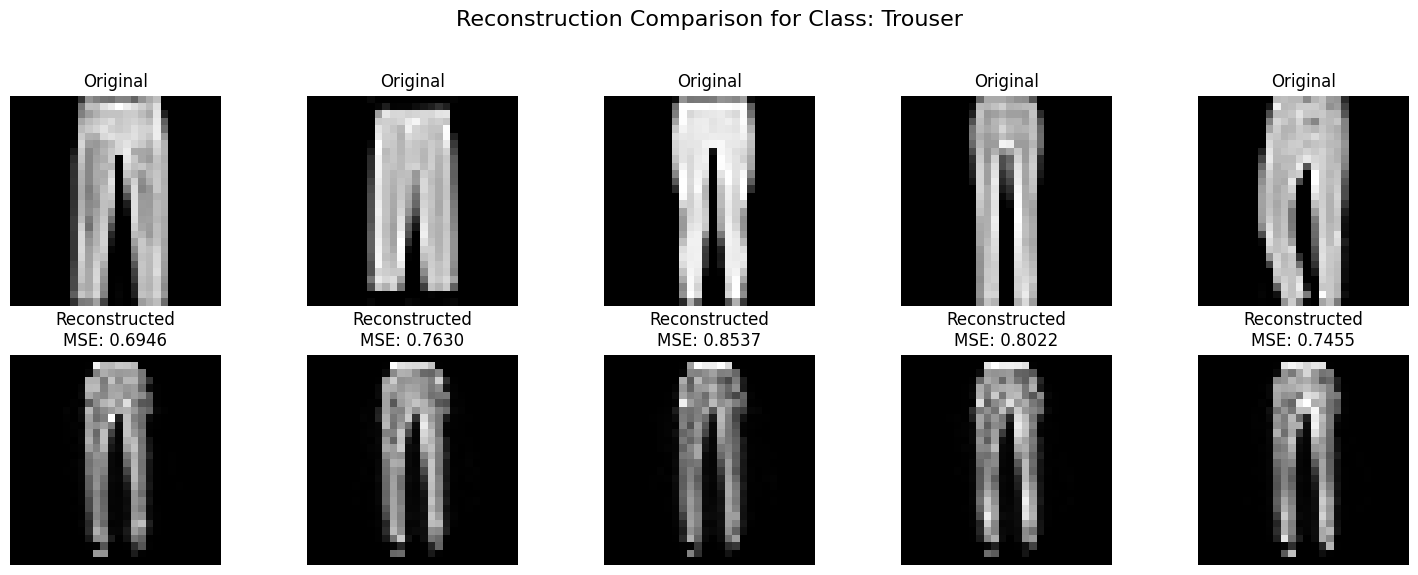

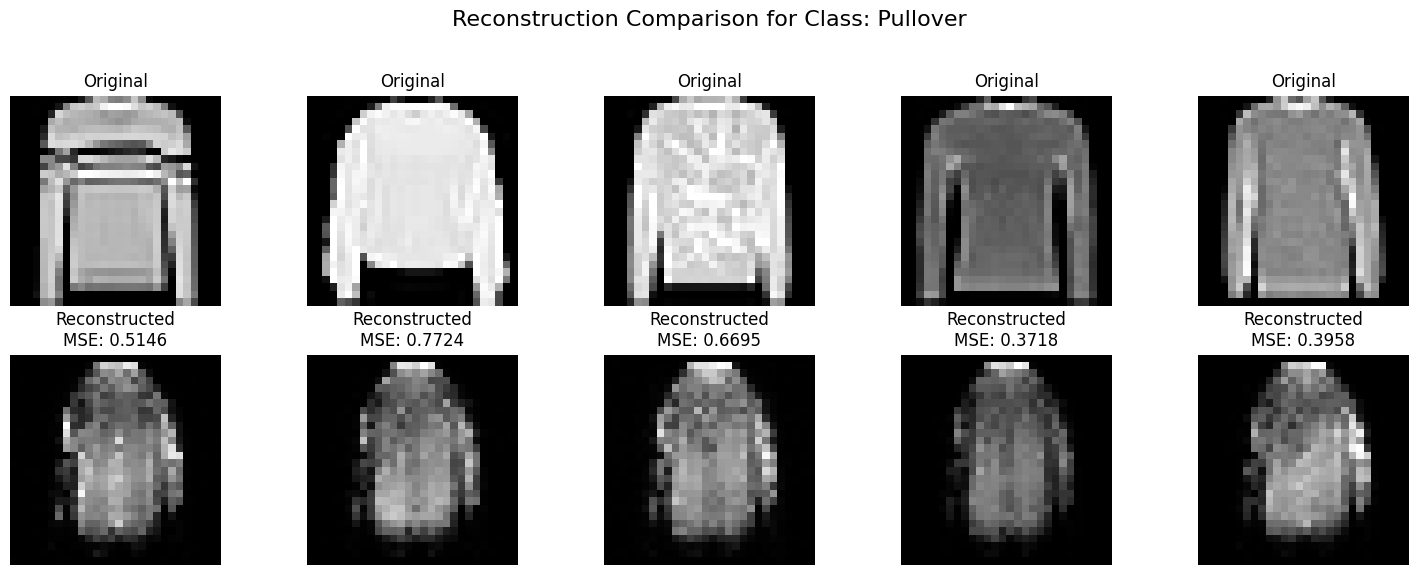

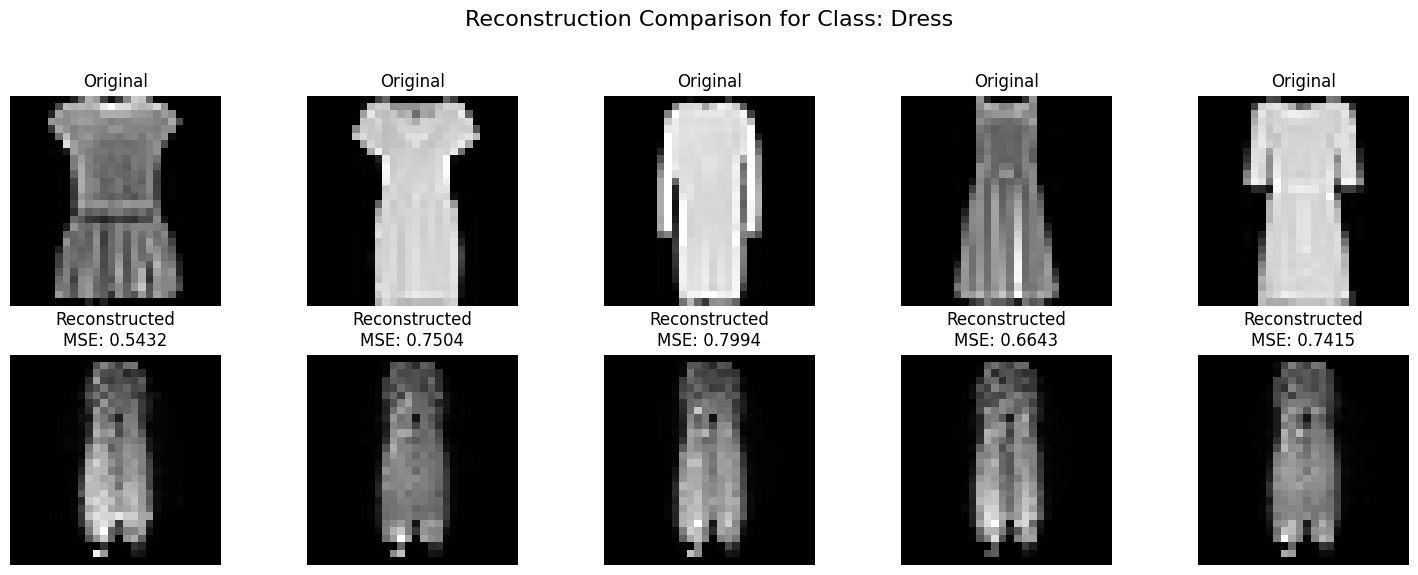

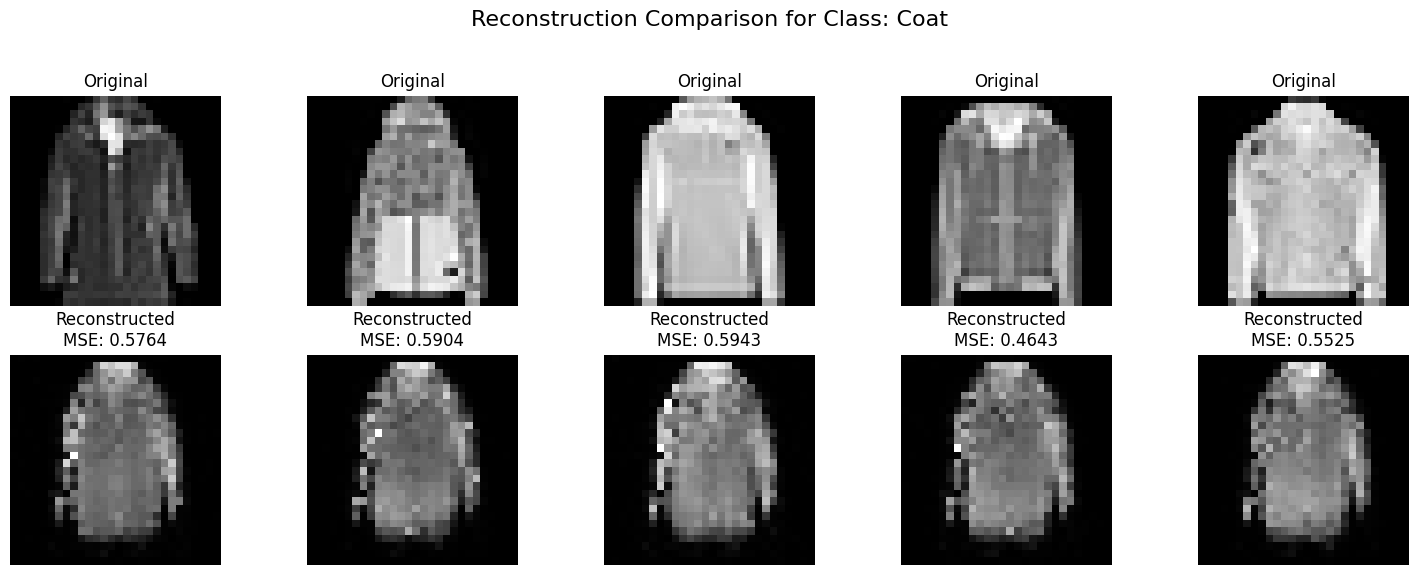

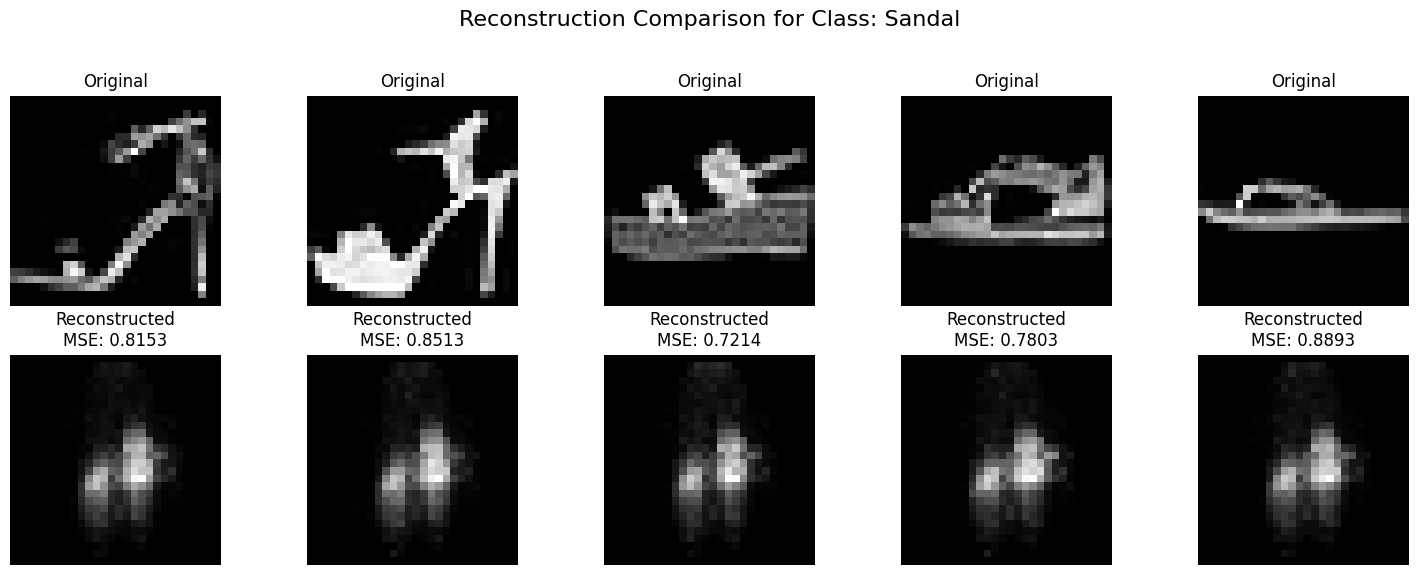

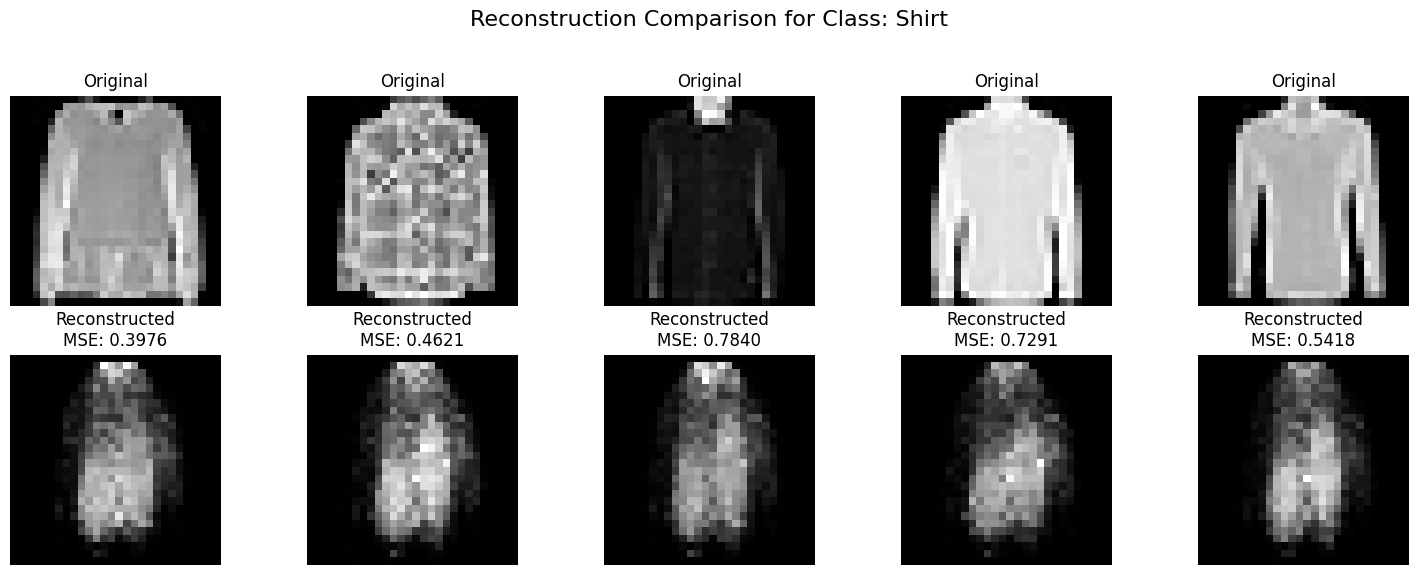

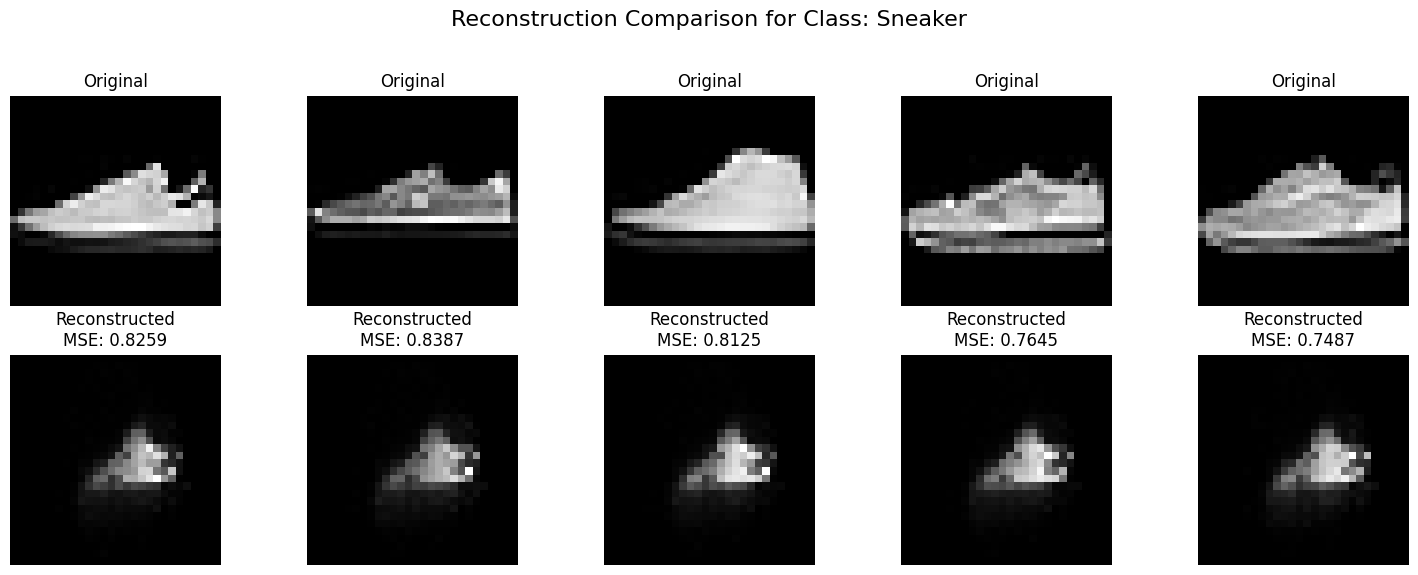

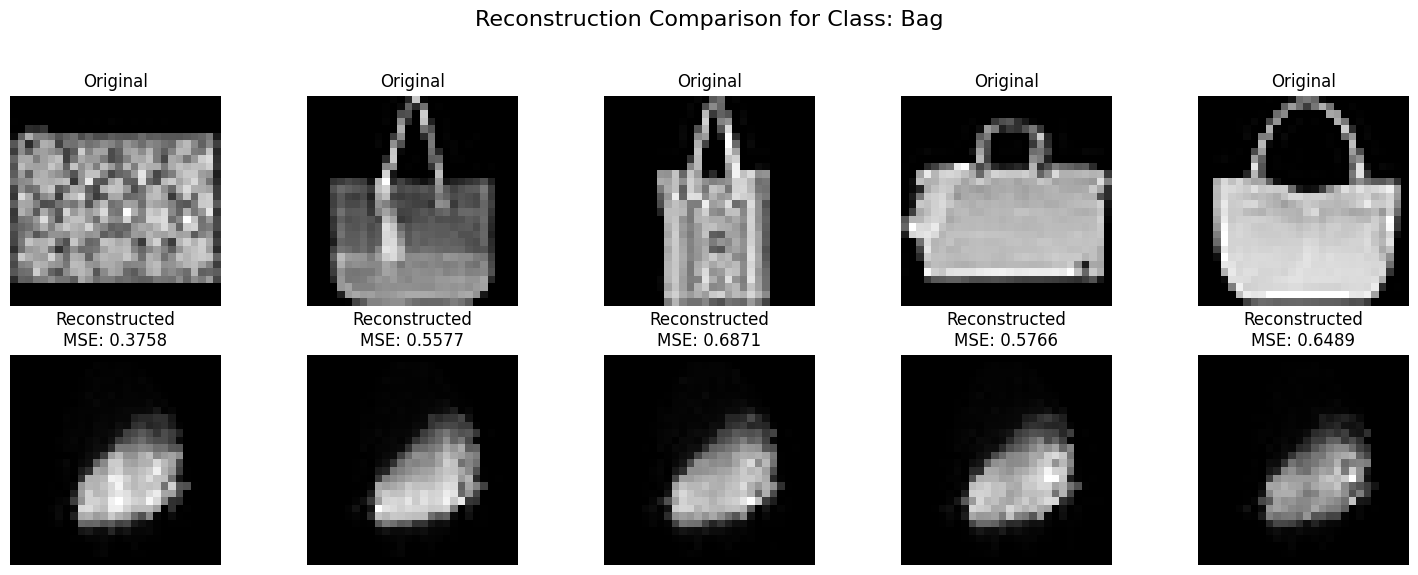

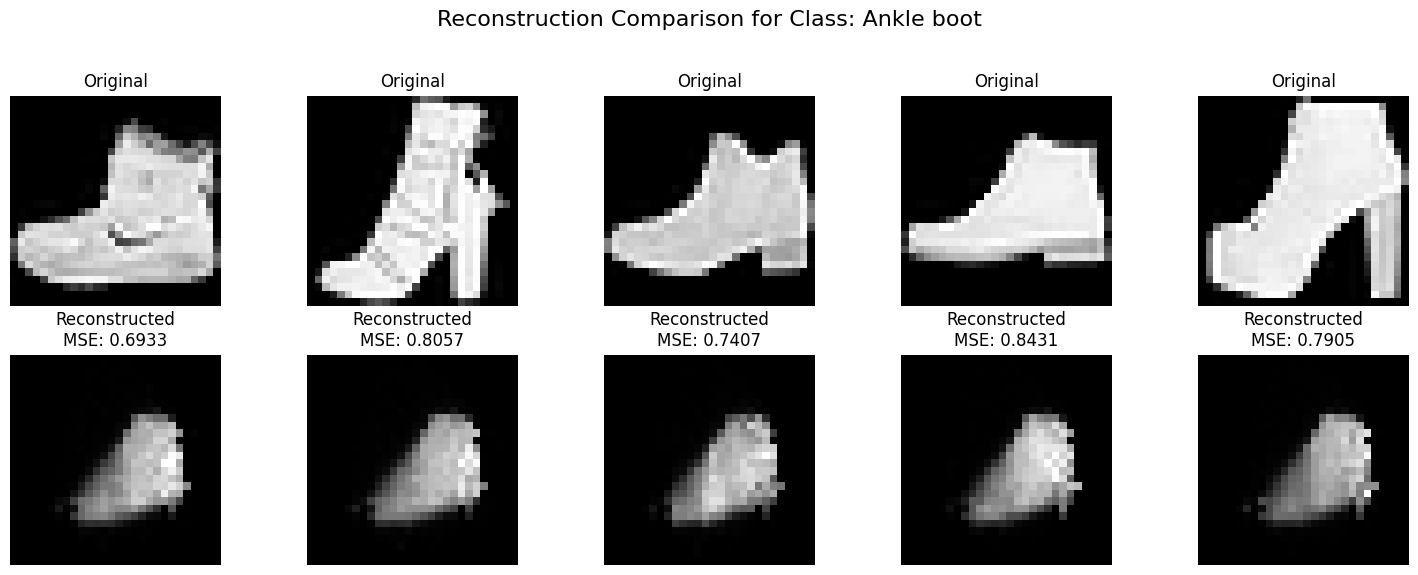

In [ ]:
def calculate_reconstruction_error(original_images, reconstructed_images):
    """Calcule l'erreur de reconstruction : Mean Squared Error (MSE)."""
    errors = []
    for original, reconstructed in zip(original_images, reconstructed_images):
        mse = np.mean((original - reconstructed)**2)
        errors.append(mse)
    return errors

def plot_reconstruction_comparison(original_images, reconstructed_images, errors, class_name):
    """Plot les images originales et leur reconstruction."""
    num_images = len(original_images)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle(f"Reconstruction Comparison for Class: {class_name}", fontsize=16)

    for i in range(num_images):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].set_title(f"Reconstructed\nMSE: {errors[i]:.4f}")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

for class_index in range(10):
    original_images_for_class = []
    for image, label in dataset:
        if label == class_index and len(original_images_for_class) < 5: #Limit to 5 images
            original_images_for_class.append(image.squeeze().numpy()) # Add original images

    reconstructed_images = new_samples[class_index]  # Get the corresponding reconstructed images

    if len(original_images_for_class) == len(reconstructed_images) : # compare same number of images
      errors = calculate_reconstruction_error(original_images_for_class, reconstructed_images)
      plot_reconstruction_comparison(original_images_for_class, reconstructed_images, errors, class_names[class_index])
    else :
      print("Error : different number of images between original and reconstructed for class " + str(class_index))


In [ ]:
def generate_new_images_from_latent(cvae, num_images=5):
    generated_images = []
    for class_index in range(10):
        class_images = []
        for _ in range(num_images):
            random_latent_vector = torch.randn(1, 20).to(DEVICE)

            label = F.one_hot(torch.tensor([class_index]), num_classes=labels_length).float().to(DEVICE)
            input_vector = torch.cat([random_latent_vector, label], dim=1)


            with torch.no_grad():
                generated_image = cvae.decode(input_vector)

            generated_image = generated_image.view(28, 28).cpu().numpy()
            class_images.append(generated_image)
        generated_images.append(class_images)
    return generated_images

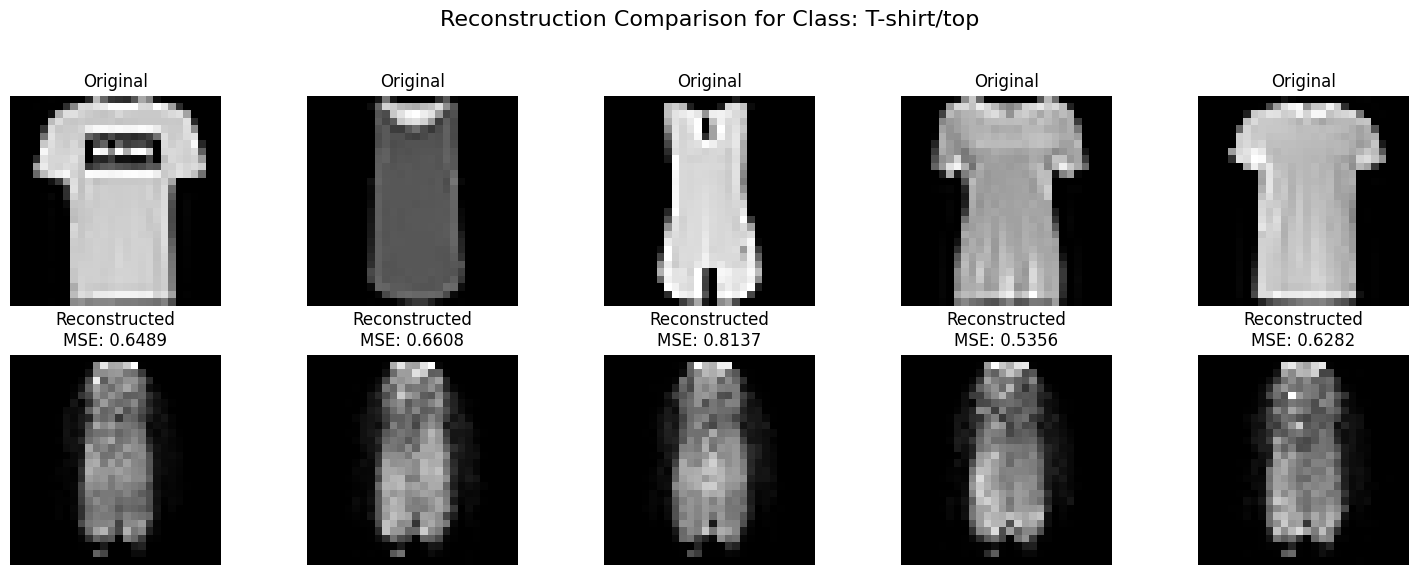

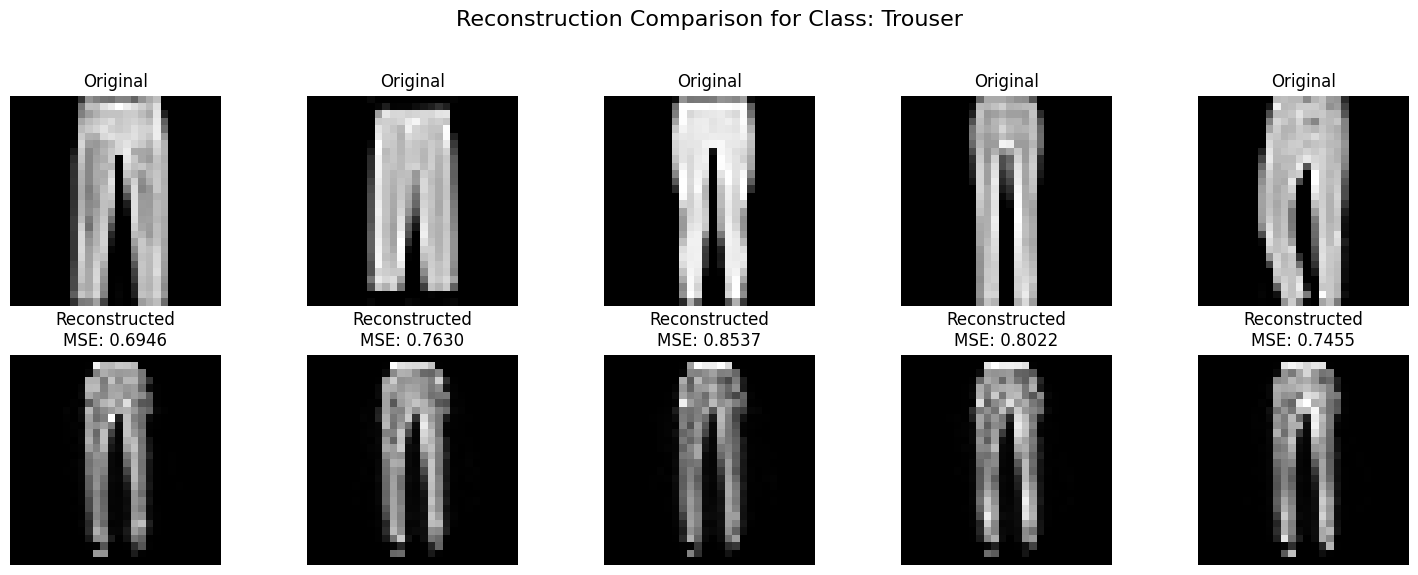

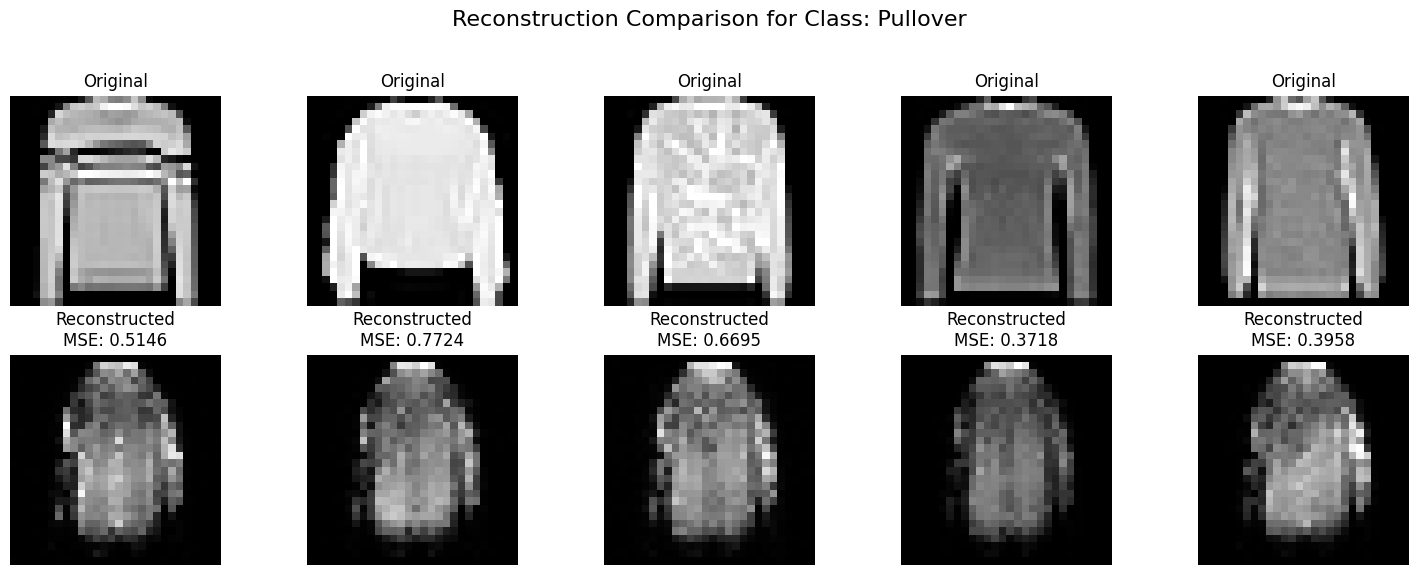

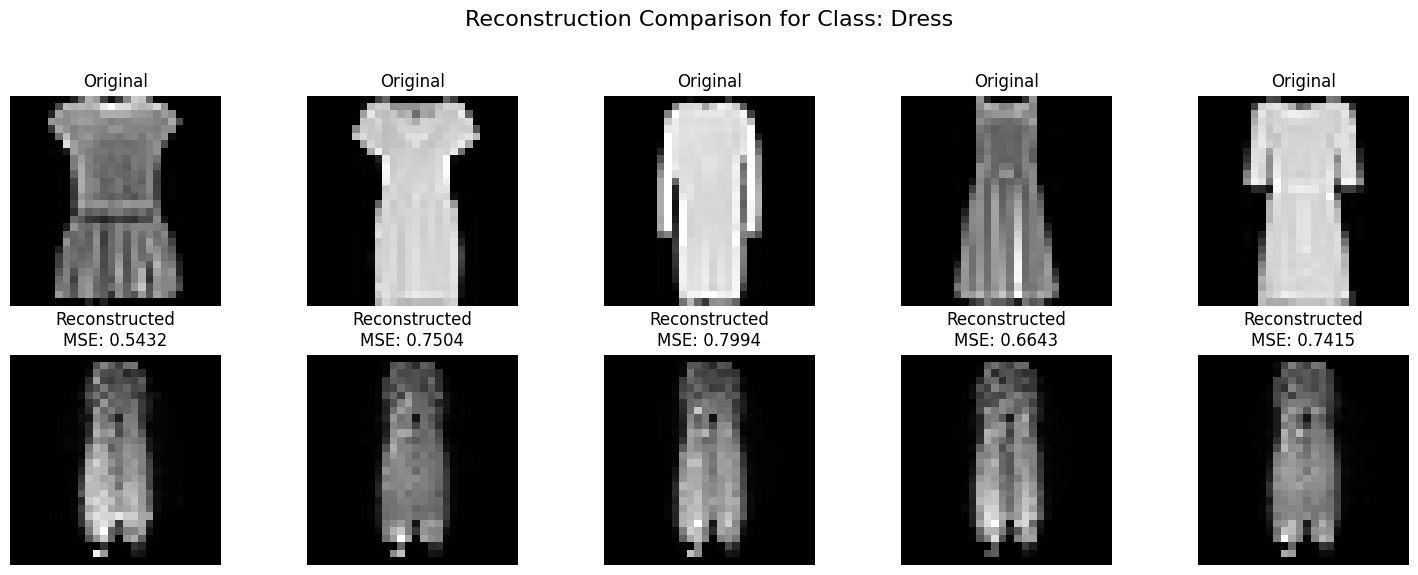

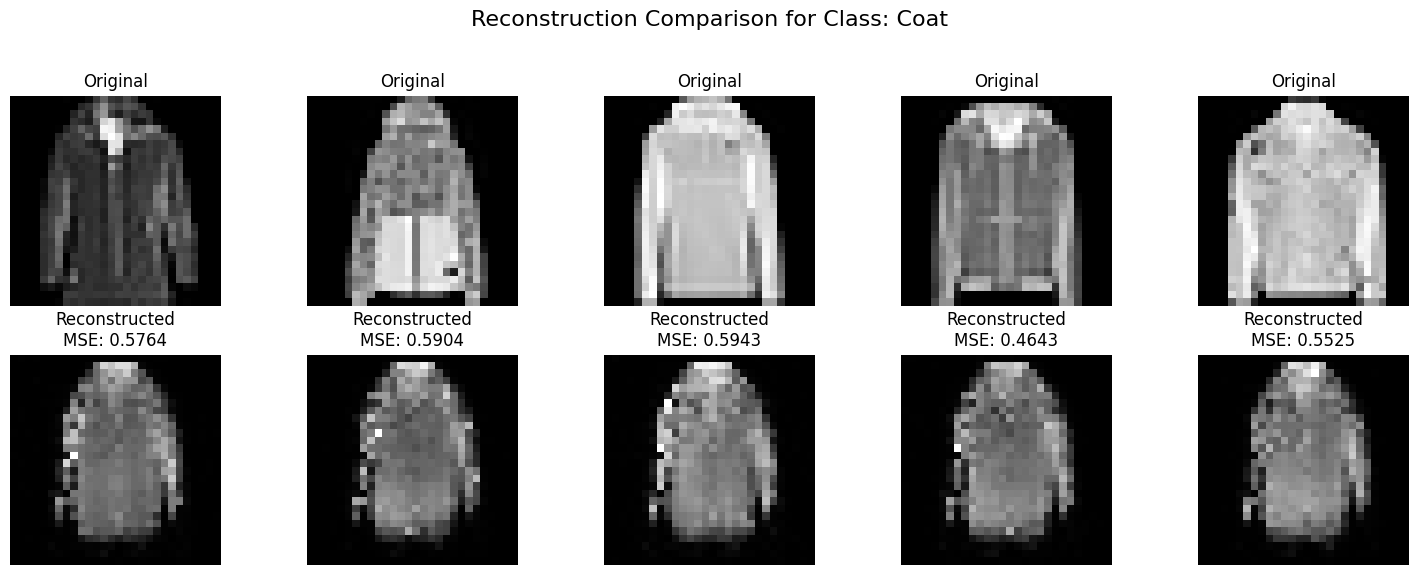

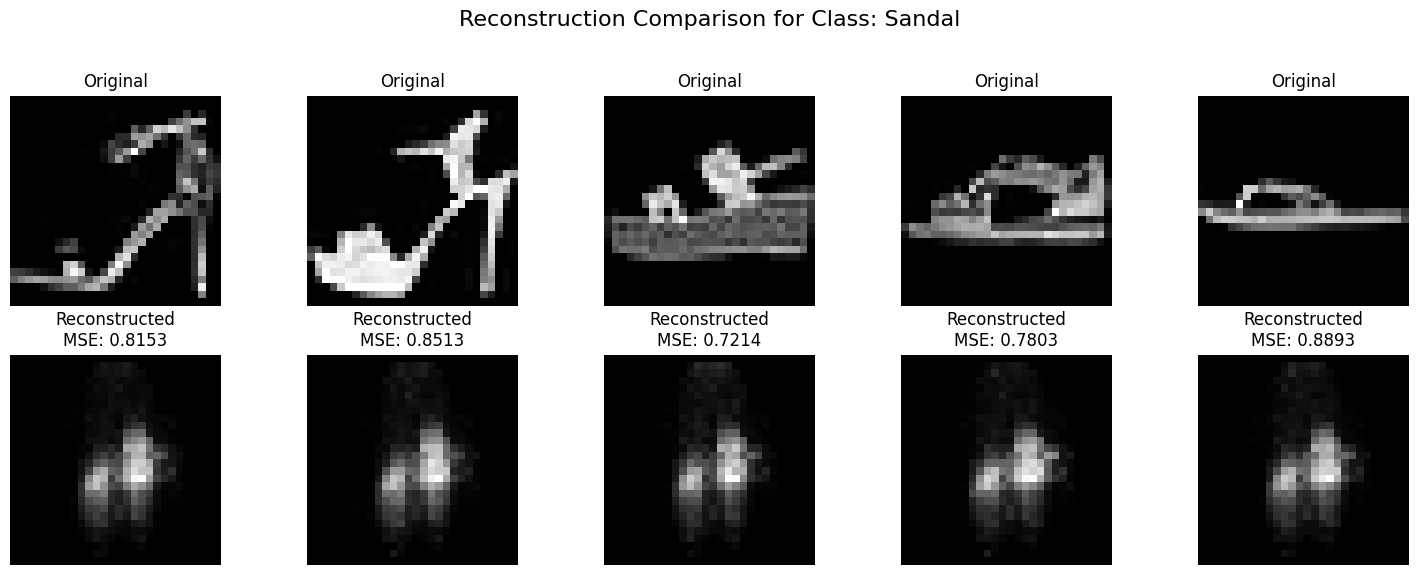

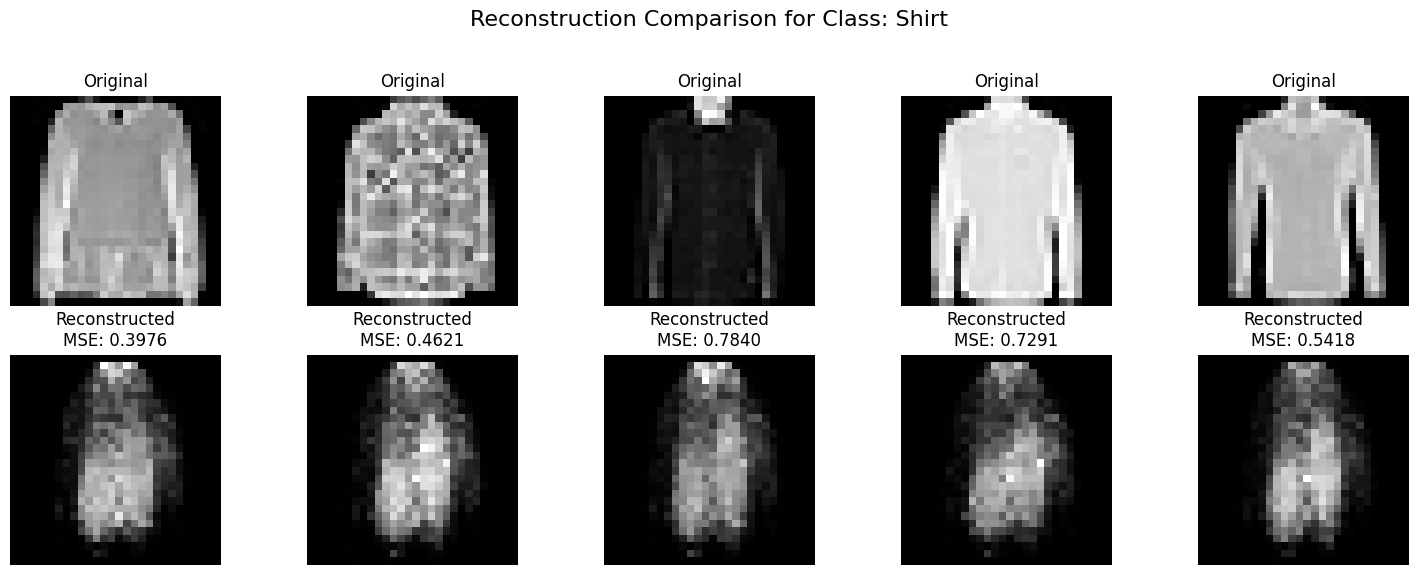

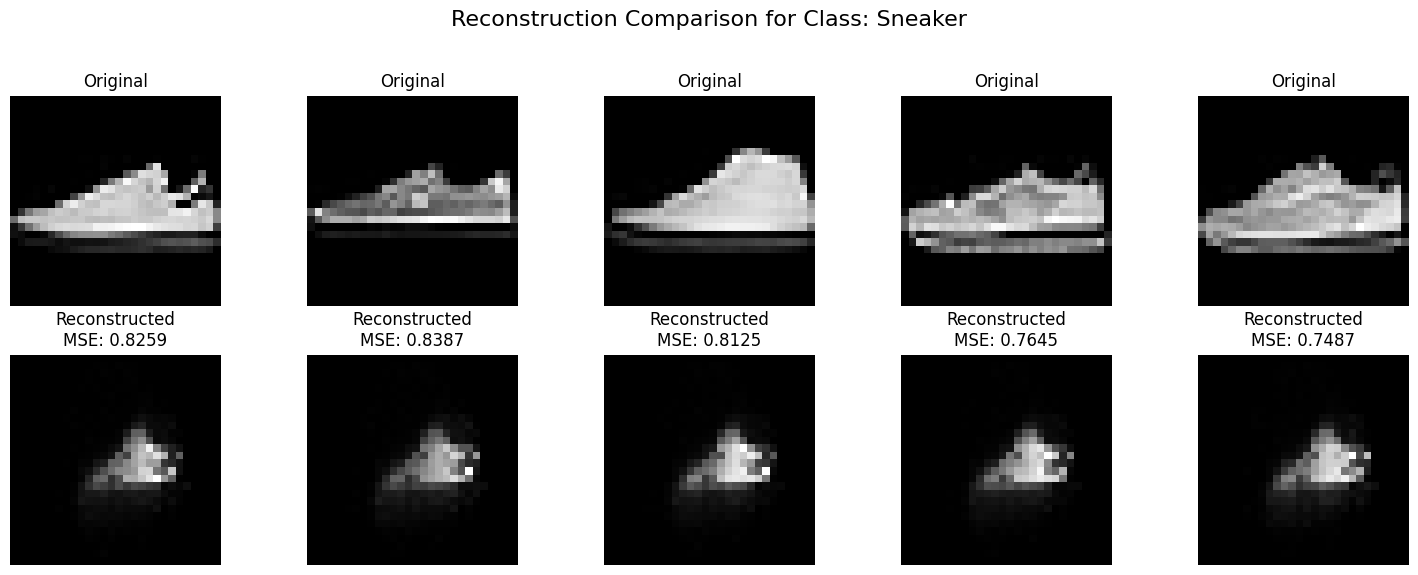

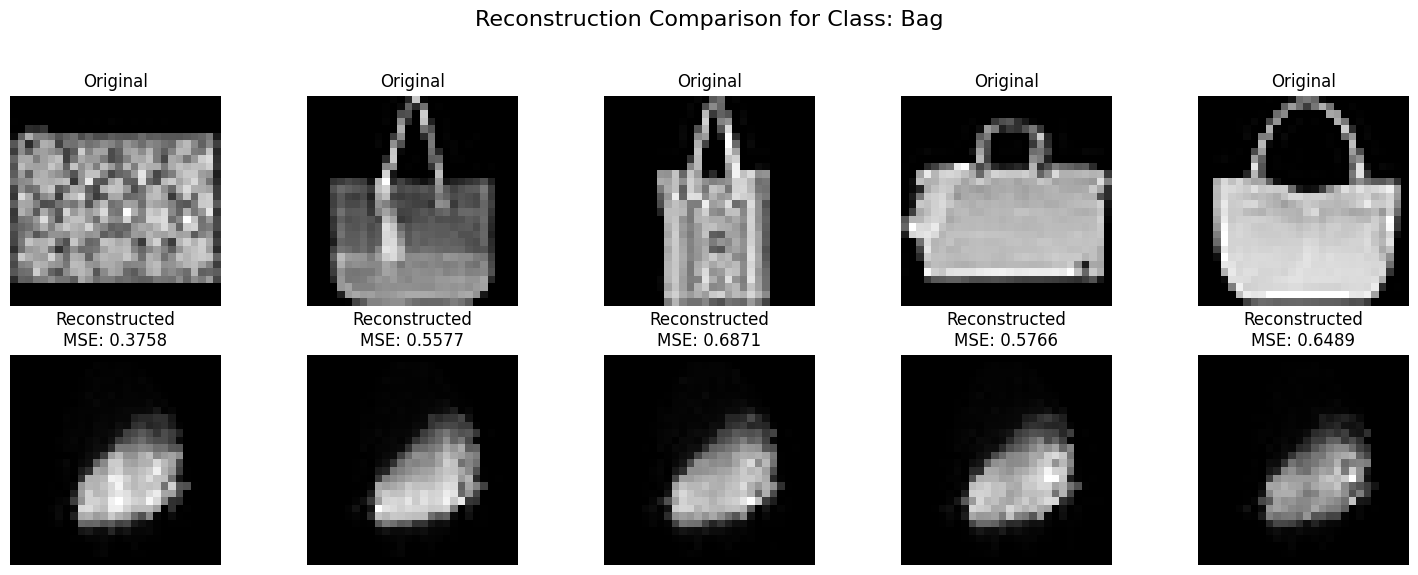

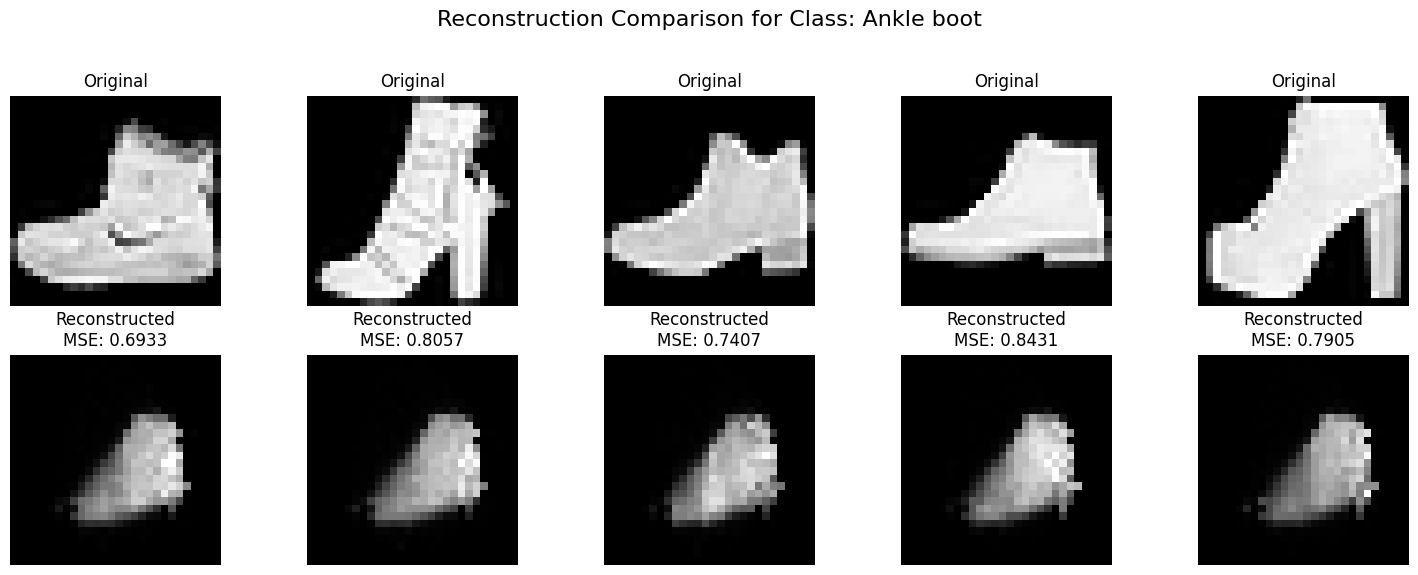

In [ ]:
def plot_reconstruction_comparison(original_images, reconstructed_images, errors, class_name):
    num_images = len(original_images)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))  # Adjust figsize as needed
    fig.suptitle(f"Reconstruction Comparison for Class: {class_name}", fontsize=16)

    for i in range(num_images):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].set_title(f"Reconstructed\nMSE: {errors[i]:.4f}")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

for class_index in range(10):
    original_images_for_class = []
    for image, label in dataset:
        if label == class_index and len(original_images_for_class) < 5: #Limit to 5 images
            original_images_for_class.append(image.squeeze().numpy()) # Add original images

    reconstructed_images = new_samples[class_index]  # Get the corresponding reconstructed images

    if len(original_images_for_class) == len(reconstructed_images) : # compare same number of images
      errors = calculate_reconstruction_error(original_images_for_class, reconstructed_images)
      plot_reconstruction_comparison(original_images_for_class, reconstructed_images, errors, class_names[class_index])
    else :
      print("Error : different number of images between original and reconstructed for class " + str(class_index))

On obtient des scores de reconstruction qui oscillent entre 0.5 à 0.8 (chaussures, boots, sneakers). Cela s'interprete par une reconstruction plutôt correcte à fragile. une MSE plus faible aurait témoigner d'une meilleure reconstruction. Le modèle pourrait mieux capter les détails des images si on **augmentait la complexité du modèle** (en ajoutant plus de couches ou des autoencoders **convolutifs**), ou **d'autres métriques** comme la Perceptual Loss pourrait permettre une évaluation plus précise de la qualité visuelle des reconstructions. Pour avoir de meilleurs résultats en général, nous devrions utiliser des **images de meilleure résolution** afin d'éviter la perte d'informations pour la reconstruction d'objets complexes, comme les **textures** ou les petites caractéristiques comme les coutures des sandales.



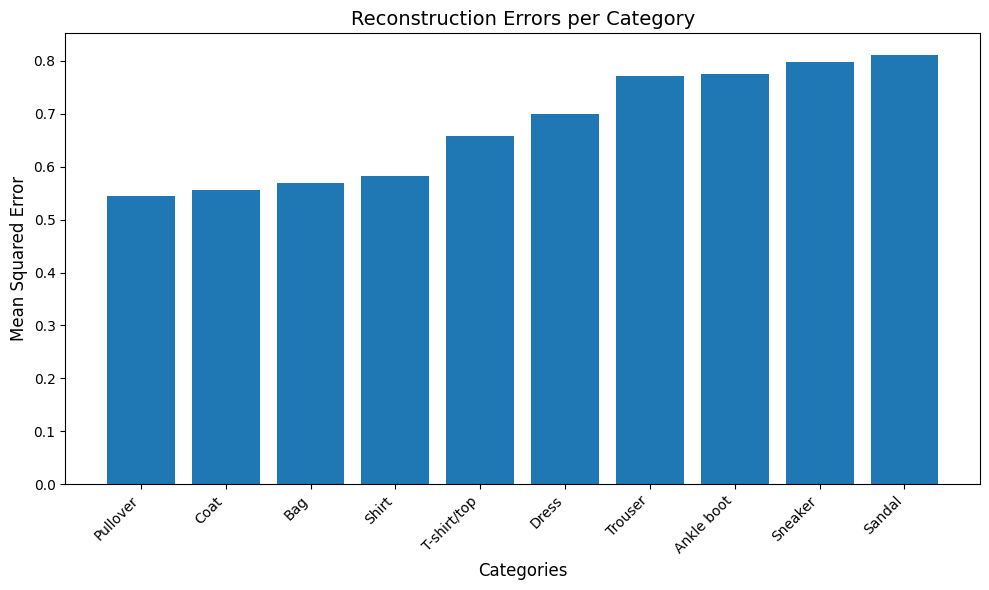

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstruction_errors(errors_per_class, class_names):
    categories = list(class_names.values())
    errors = [np.mean(errors) for errors in errors_per_class]

    # Tri
    sorted_errors, sorted_categories = zip(*sorted(zip(errors, categories)))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_categories, sorted_errors)
    plt.xlabel("Categories", fontsize=12)
    plt.ylabel("Mean Squared Error", fontsize=12)
    plt.title("Reconstruction Errors per Category", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

errors_per_class = []
for class_index in range(10):
    original_images_for_class = []
    for image, label in dataset:
        if label == class_index and len(original_images_for_class) < 5:
            original_images_for_class.append(image.squeeze().numpy())

    reconstructed_images = new_samples[class_index]
    if len(original_images_for_class) == len(reconstructed_images):
        errors = calculate_reconstruction_error(original_images_for_class, reconstructed_images)
        errors_per_class.append(errors)
    else:
        print("Error: Different number of images between original and reconstructed for class", class_index)


plot_reconstruction_errors(errors_per_class, class_names)

**Solutions pour les plus mauvaises reconstructions:**

Les sandales, sneakers et chaussues peuvent être des classes particulièrement difficiles à reconstruire car elles présentent de la **variabilité dans leurs apparences au sein de la même classe**. Les sandales peuvent varier largement en termes de style (avec ou sans lanières, avec des décors, ouvertes ou fermées) et cela rend difficile d’apprendre une **représentation latente unique** qui capture toutes les variations permettant une reconstruction précise.

De plus, ces **classes peuvent aussi se mélanger**. En effet, les sneakers et les sandales ont des propriétés visuelles avec les bottes, les chaussures à talons, etc. qui rend difficile de différencier clairement ces objets, entraînant des reconstructions plutôt mauvaises.


**Solution:** utiliser des architectures plus complexes, comme les U-Nets ou les autoencodeurs convolutifs qui sont mieux équipées pour capturer les détails fins et les relations spatiales complexes dans les images.

#**Conclusion**

L'implémentation d'un modèle par CVAE est un vrai plus pour les données de Fashion-MNIST : la classification était bien mieux réussi qu'avec un réseau de neuronnes standard.
Le CVAE permet de générer des images spécifiques à un label donné, permettant un contrôle précis sur la génération d'échantillons. Sa modélisation conditionnelle permet de produire des échantillons diversifiés et corrects. Il apprend une représentation latente structurée, facilitant la génération réaliste d'instances variées. Contrairement à un réseau standard, le CVAE est mieux adapté pour des tâches conditionnelles, où le contrôle sur l'étiquette ou le contexte est essentiel.


**Ressources :**

https://www.kaggle.com/code/averkij/conditional-variational-autoencoder-and-t-sne



 https://pyro.ai/examples/cvae.html

https://www.datacamp.com/tutorial/variational-autoencoders

 https://pyro.ai/examples/cvae.html